# Modelo de predicción de inscripciones estudiantiles mediante técnicas de Machine Learning

**Maestría en Inteligencia Artificial Aplicada**

**Proyecto Integrador Sep-Nov 2025**

**Equipo 14**

**Integrantes:**

- Alejandro Roa Solis – A01129942
- Annette Cristina Narvaez Andrade – A00571041
- Karla Alejandra Fonseca Márquez – A01795313


**Patrocinador Tec de Monterrey:**

Dr. Juan Arturo Nolazco Flores, Director del Hub de Ciencias y Datos de la Escuela de Ingeniería del Tec de Monterrey

## Fuentes de datos

Para este proyecto contamos con **cuatro fuentes principales de información**, cada una integrada por uno o varios archivos en formato CSV que provienen de sistemas institucionales de gestión académica y administrativa:

1. **Solicitud**: concentra información detallada del proceso de admisión, con datos sociodemográficos, académicos y administrativos de los prospectos.  
2. **Becas**: registros de solicitudes y asignaciones de becas, que reflejan condiciones económicas y apoyos financieros otorgados a los estudiantes.  
3. **Otro_becas**: complementa la fuente anterior con datos adicionales de participación en procesos de becas, postulaciones, resultados y porcentajes asignados.  
4. **Inscritos**: indica si un prospecto se convirtió finalmente en estudiante inscrito (variable binaria que servirá como objetivo en el modelado)

En conjunto, estas fuentes conforman un ecosistema de datos heterogéneo, donde algunas variables corresponden a identificadores y llaves de integración, otras son métricas numéricas (ej. montos, puntajes, días de proceso) y muchas son categóricas (ej. nivel académico, campus, programa). La combinación de todas permite construir una vista integrada para el análisis exploratorio (EDA) y el modelado posterior.


In [3]:
# === Configuración general ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

# Rutas: cada fuente acepta lista de CSVs (se concatenan)
RUTAS = {
    "solicitud": ["data/4_solicitud.csv"],
    "becas": [
        "data/1_becas.csv",
    ],
    "inscritos": ["data/5_inscritos.csv"],
    "otro_becas": [
        "data/2_1_becas.csv",
        "data/2_2_becas.csv",
        "data/2_3_becas.csv",
        "data/2_4_becas.csv",
    ],
}

# Definición de claves
KEYS = {
    "solicitud": {"pk": "contacto_numero"},
    "becas": {"fk": "solicitante_numero"},
    "inscritos": {"fk": "id_persona"},
    "otro_becas": {"fk": "id_persona"},
}

# Columnas de fecha a parsear
COLUMNAS_FECHA = {
    "solicitud": [
        "FECHA_POTENCIAL","FECHA_SOLICITUD_INICIADA","FECHA_ENTREGA_REQUISITOS",
        "FECHA_EXPEDIENTE_COMPLETO","FECHA_COMITE_DECISIONES","FECHA_ADMITIDO",
        "FECHA_INSCRITO_CON_PAGO_PARCIAL","FECHA_INSCRITO","FECHA_ULTIMA_ENTREGA_REQUISITOS",
        "FECHA_ULTIMO_EXPEDIENTE_COMPLETO","FECHA_INSERCION_CARGA","FECHA_MODIFICACION_CARGA"
    ],
    "becas": [
        "FECHA_SOLICITUD_INICIADA","FECHA_EXPEDIENTE_COMPLETO","FECHA_COMITE_DECISIONES",
        "FECHA_SELECCIONADO","FECHA_BECADO","FECHA_ULTIMA_SOLICITUD_INICIADA",
        "FECHA_ULTIMO_EXPEDIENTE_COMPLETO","FECHA_INSERCION_CARGA","FECHA_MODIFICACION_CARGA"
    ],
    "inscritos": [],
    "otro_becas": [],
}

# Lectura parcial (None = todo)
NROWS = None

# Parámetros de visualización automática
TOP_N_NUM = 10
TOP_N_CAT = 10

# Variable objetivo
TARGET = "inscrito"


In [4]:
# === Utilidades ===
def cargar_csvs(paths, parse_dates=None, nrows=None):
    if isinstance(paths, str):
        paths = [paths]
    frames = []
    for p in paths:
        if not os.path.exists(p):
            raise FileNotFoundError(f"No existe el archivo: {p}")
        kw = {}
        if parse_dates:
            kw["parse_dates"] = parse_dates
        df = pd.read_csv(p, **kw, nrows=nrows, low_memory=False)
        frames.append(df)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

def info_basica(df, nombre):
    print(f"\n== {nombre} ==")
    print("Forma:", df.shape)
    print("\nTipos de datos:")
    print(df.dtypes)
    print("\n% Nulos por columna:")
    print((df.isna().mean()*100).round(2).sort_values(ascending=False))
    print("\nCardinalidad (número de valores únicos):")
    print(df.nunique().sort_values(ascending=False))

def duplicados_resumen(df, claves=None):
    if claves and all(c in df.columns for c in claves):
        dups = df.duplicated(subset=claves, keep=False).sum()
        print(f"Duplicados por claves {claves}: {dups}")
    print("Duplicados globales:", df.duplicated(keep=False).sum())

def barras_frecuencias(df, col, top=20):
    s = df[col].astype(str).fillna("NA").value_counts().head(top)
    plt.figure(figsize=(8,5))
    plt.bar(s.index, s.values)
    plt.title(f"Top {top} frecuencias — {col}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

def histograma(df, col, bins=30):
    vals = df[col].dropna()
    if vals.empty:
        print(f"Sin datos para {col}")
        return
    plt.figure(figsize=(8,5))
    plt.hist(vals, bins=bins)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

def boxplot(df, col):
    vals = df[col].dropna()
    if vals.empty:
        print(f"Sin datos para {col}")
        return
    plt.figure(figsize=(6,5))
    plt.boxplot(vals, vert=True)
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.show()

def correlacion_heatmap(df_num):
    if df_num.shape[1] < 2:
        print("Se requieren >= 2 columnas numéricas para correlación.")
        return
    corr = df_num.corr(numeric_only=True)
    plt.figure(figsize=(15,15))
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.title("Matriz de correlación (Pearson)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def iqr_outlier_mask(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return pd.Series(False, index=s.index)
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (s < lower) | (s > upper)

def mad_outlier_mask(s):
    med = s.median()
    mad = (s - med).abs().median()
    if mad == 0:
        return pd.Series(False, index=s.index)
    z = 0.6745 * (s - med) / mad
    return z.abs() > 3.5


In [5]:
# === Carga de datos ===
dfs = {}
for nombre, paths in RUTAS.items():
    if not paths:
        continue
    parse_cols = COLUMNAS_FECHA.get(nombre, [])
    dfs[nombre] = cargar_csvs(paths, parse_dates=parse_cols, nrows=NROWS)
    info_basica(dfs[nombre], nombre)



== solicitud ==
Forma: (23135, 127)

Tipos de datos:
ID                                       object
NAME                                     object
CONTACTO_ID                              object
CONTACTO_PIDM                            object
ETAPA                                    object
                                   ...         
ENVIADO_DWH                              object
FECHA_INSERCION_CARGA       datetime64[ns, UTC]
FECHA_MODIFICACION_CARGA    datetime64[ns, UTC]
normalized_id                            object
contacto_numero                          object
Length: 127, dtype: object

% Nulos por columna:
PRIORIDAD                    100.0
CLAVE_UNIDAD_DE_NEGOCIO      100.0
FOLIO_SOLICITUD_DUPLICADA    100.0
PREDICCION                   100.0
EDAD_AL_INICIAR              100.0
                             ...  
FECHA_ENTREGA_REQUISITOS       0.0
FECHA_SOLICITUD_INICIADA       0.0
FECHA_POTENCIAL                0.0
ULTIMO_RESULTADO_FOLIO         0.0
contacto_numero    

## Integración de fuentes de datos

Con el fin de contar con una vista unificada para el análisis exploratorio, se integraron las cinco fuentes en un solo **DataFrame maestro**. La tabla base seleccionada fue **`solicitud`** (una fila por prospecto), sobre la cual se realizaron uniones (*joins*) con las demás fuentes siguiendo las llaves foráneas identificadas (`contacto_numero` ↔ `id_persona` / `solicitante_numero`). Dado que varias fuentes presentan relaciones de tipo **uno a muchos** (por ejemplo, un mismo solicitante puede tener múltiples registros de beca), se aplicaron técnicas de **agregación previa** (conteos, máximos, sumas) para evitar la duplicación de filas en la tabla maestra. El resultado es un **DataFrame integrado** en el que cada registro corresponde a un prospecto único, enriquecido con información de becas, inscripción y continuidad, lo que facilita el EDA y prepara el terreno para etapas posteriores de modelado.


In [7]:
# === Validaciones clave ===
# Unicidad y nulos en llaves
for nombre, cfg in KEYS.items():
    if nombre not in dfs:
        continue
    key = cfg.get("pk") or cfg.get("fk")
    if key and key in dfs[nombre].columns:
        print(f"\n[{nombre}] Nulos en {key}: {int(dfs[nombre][key].isna().sum())}")
        print(f"[{nombre}] Duplicados en {key}: {int(dfs[nombre][key].duplicated().sum())}")

# Cruce directo esperado: contacto_numero ≡ id_persona
if "solicitud" in dfs and "inscritos" in dfs:
    set_contacto = set(dfs["solicitud"]["contacto_numero"].dropna().unique())
    set_idpersona = set(dfs["inscritos"]["id_persona"].dropna().unique())
    inter = set_contacto.intersection(set_idpersona)
    print("\nCoincidencias exactas contacto_numero ↔ id_persona:", len(inter))



[solicitud] Nulos en contacto_numero: 0
[solicitud] Duplicados en contacto_numero: 0

[becas] Nulos en solicitante_numero: 4
[becas] Duplicados en solicitante_numero: 6512

[inscritos] Nulos en id_persona: 1
[inscritos] Duplicados en id_persona: 4

[otro_becas] Nulos en id_persona: 0
[otro_becas] Duplicados en id_persona: 566340

Coincidencias exactas contacto_numero ↔ id_persona: 23135


In [8]:
# === Agregaciones para evitar muchos-a-muchos ===
# Becas por solicitante_numero
agg_becas = None
if "becas" in dfs and "solicitante_numero" in dfs["becas"].columns:
    b = dfs["becas"].copy()
    for col in ["OFRECIMIENTO_FRANQUICIA_BECA_OFRECIDA","INGRESOS","EGRESOS"]:
        if col in b.columns:
            b[col] = pd.to_numeric(b[col], errors="coerce")
    agg_dict = {"ID":"count"}
    if "OFRECIMIENTO_FRANQUICIA_BECA_OFRECIDA" in b.columns:
        agg_dict["OFRECIMIENTO_FRANQUICIA_BECA_OFRECIDA"] = "max"
    if "ESTATUS_BECA" in b.columns:
        agg_dict["ESTATUS_BECA"] = lambda x: x.mode().iat[0] if not x.mode().empty else None
    if "FECHA_BECADO" in b.columns:
        agg_dict["FECHA_BECADO"] = "max"
    agg_becas = b.groupby("solicitante_numero").agg(agg_dict).rename(columns={
        "ID":"becas_total",
        "OFRECIMIENTO_FRANQUICIA_BECA_OFRECIDA":"beca_pct_max",
        "ESTATUS_BECA":"beca_estatus_moda",
        "FECHA_BECADO":"beca_fecha_becado_max",
    }).reset_index()

# otro_becas por id_persona
agg_otro = None
if "otro_becas" in dfs and "id_persona" in dfs["otro_becas"].columns and len(dfs["otro_becas"])>0:
    ob = dfs["otro_becas"].copy()
    for col in ["PORCENTAJE_BECA","POSTULA_BECA","GANA_BECA"]:
        if col in ob.columns:
            ob[col] = pd.to_numeric(ob[col], errors="coerce")
    agg_dict = {"CLAVE_BECA":"count"}
    if "PORCENTAJE_BECA" in ob.columns:
        agg_dict["PORCENTAJE_BECA"] = "max"
    if "GANA_BECA" in ob.columns:
        agg_dict["GANA_BECA"] = "sum"
    agg_otro = ob.groupby("id_persona").agg(agg_dict).rename(columns={
        "CLAVE_BECA":"otro_becas_total",
        "PORCENTAJE_BECA":"otro_porcentaje_max",
        "GANA_BECA":"otro_gana_sum",
    }).reset_index()

# inscritos: 1 por id_persona
agg_ins = None
if "inscritos" in dfs and "id_persona" in dfs["inscritos"].columns:
    ins = dfs["inscritos"].copy()
    if "inscrito" in ins.columns:
        ins["inscrito"] = pd.to_numeric(ins["inscrito"], errors="coerce")
    agg_ins = ins.groupby("id_persona").agg(inscrito=("inscrito","max")).reset_index()


In [9]:
# === Vista integrada completa ===
integrado = None
if "solicitud" in dfs:
    integrado = dfs["solicitud"].copy()

    # solicitud + becas (agregado) por contacto_numero = solicitante_numero
    if agg_becas is not None:
        integrado = integrado.merge(
            agg_becas, how="left",
            left_on="contacto_numero", right_on="solicitante_numero",
            validate="one_to_one"
        )

    # solicitud + inscritos por contacto_numero = id_persona
    if agg_ins is not None:
        integrado = integrado.merge(
            agg_ins, how="left",
            left_on="contacto_numero", right_on="id_persona",
            validate="many_to_one"
        )

    # solicitud + otro_becas (agregado) por contacto_numero = id_persona
    if agg_otro is not None:
        integrado = integrado.merge(
            agg_otro, how="left",
            left_on="contacto_numero", right_on="id_persona",
            validate="many_to_one"
        )

print("Dimensiones de la vista integrada:", None if integrado is None else integrado.shape)
if integrado is not None:
    display(integrado.head(3))


Dimensiones de la vista integrada: (23135, 138)


,ID,NAME,CONTACTO_ID,CONTACTO_PIDM,ETAPA,ESTATUS,ESTATUS_ADMISION_CLAVE,MOTIVO_DESCARTE_FOLIO,DESCRIPCION_DESCARTE,SEDE_ATENCION_CLAVE_BANNER,NIVEL_COMERCIAL_CLAVE_NIVEL,PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,CAMPUS_SEDE_COMERCIAL_CLAVE_BANNER,MODALIDAD_COMERCIAL,AGRUPACION_COMERCIAL_CLAVE,PROGRAMA_ACADEMICO_COMERCIAL_CLAVE,ORIGEN_SOLICITUD,DETALLE_ORIGEN,RED_SOCIAL,CAMPANIA_ORIGEN_CLAVE,EVENTO_ORIGEN_EVENTKEY,REFERENTE_ID,ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER,NIVEL_CLAVE_NIVEL,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO,CONFIGURACION_OFERTA_CAMPUS_SEDE_CLAVE_BANNER,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE,PROGRAMA_ACADEMICO_CLAVE_PLAN_ESTUDIOS,SEDE_INDICADOR_CLAVE_BANNER,SEDE_EGRESO_DESTINO_CAMPUS_CLAVE_BANNER,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE,PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,PRUEBA_ADMISION_CONSIDERADA_FECHA,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE,PRUEBA_INGLES_CONSIDERADA_PUNTAJE,PRUEBA_INGLES_CONSIDERADA_FECHA,PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE,ESCOLARIDA_ADANTERIOR_PROMEDIO,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL,ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE,ESCOLARIDA_ADANTERIOR_ESTATUS,ESCOLARIDA_ADANTERIOR_PERFIL,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS,ESCOLARIDA_ADANTERIOR_COMPROBANTE,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION,PUNTAJE_TOTAL_RUBRICA,PERFIL,RESULTADO_DE_RUBRICA_NAME,BLOQUE_ADMISION_NAME,TIPO_ADMISION_CLAVE,ATRIBUTOS,...,FECHA_ULTIMA_ENTREGA_REQUISITOS,FECHA_ULTIMO_EXPEDIENTE_COMPLETO,DIAS_POTENCIAL,DIAS_SOLICITUD_INICIADA,DIAS_ENTREGA_REQUISITOS,DIAS_EXPEDIENTE_COMPLETO,DIAS_COMITE_DECISIONES,DIAS_ADMITIDO,DIAS_INSCRITO_CON_PAGO_PARCIAL,DIAS_ULTIMA_ENTREGA_REQUISITOS,SOLICITUD_CERRADA,ETAPA_EMBUDO,PRIORIDAD,REL_DOCUMENTOS_AUTORIZADOS,ACTUAL,IND_EMB_SOLP,IND_EMB_SOL,IND_ETA_ADM,IND_ETA_IPP,IND_ETA_INS,IND_ETA_EXP,IND_ETA_COM,IND_ETA_ENT,IND_ETA_POT,IND_ETA_SOI,PROPIETARIO,ESCUELA_NACIONAL_CLAVE,IDIOMA_CLAVE,ESTATUS_PREPARACION_INSCRIPCION,PROBABILIDAD_INSCRIPCION,ESTATUS_PROBABILIDAD_INSCRIPCION,RECOMENDACION_INSCRIPCION,EDAD_AL_INICIAR,PREDICCION,SIGUIENTE_BLOQUE,FOLIO_SOLICITUD_DUPLICADA,ALERTAS,ALERTAS_POR_REVISAR,CUENTA_CONOCIMIENTO_DE_IDIOMA,PRIMER_DESCARTE,ULTIMO_DESCARTE,CLAVE_UNIDAD_DE_NEGOCIO,HASH_CARGA,IND_ELIMINADO_CARGA,ENVIADO_DWH,FECHA_INSERCION_CARGA,FECHA_MODIFICACION_CARGA,normalized_id,contacto_numero,solicitante_numero,becas_total,beca_pct_max,beca_estatus_moda,beca_fecha_becado_max,id_persona_x,inscrito,id_persona_y,otro_becas_total,otro_porcentaje_max,otro_gana_sum
0,a3WUG000000rb9V2AQ,APP-311643,003UG00000F1EebYAF,"610,458",Inscrito,Activa,AD,NaN,NaN,MTY,NaN,NaN,NaN,NaN,NaN,NaN,Solicitud,NaN,NaN,NaN,NaN,NaN,NaN,5,202513,MTY,SLD,LNB19,NaN,NaN,E03T,1342.0,2024-11-30T00:00:00.000Z,202417.0,G4,NaN,NaN,NaN,NaN,NaN,84.0,NaN,5,C00001,IIA07,T,Tec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,Entrega 15,M5,NaN,...,2024-12-12 00:00:00+00:00,2025-01-14 00:00:00+00:00,0,6,34,2,49,114,26.0,33,NaN,Inscrito,NaN,100,NaN,1,1,1,1,1,1,1,1,1,1,0052M000008JYtwQAG,CS,NaN,Listo,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FBA6B191D03A6F10D1EAB44E90E6DB6E,N,N,2024-11-13 00:00:00+00:00,2025-02-09 00:00:00+00:00,00610456,8febac3bc1d5,NaN,NaN,NaN,NaN,NaT,8febac3bc1d5,0,8febac3bc1d5,13.0,0.0,0.0
1,a3WUG000001PI2n2AG,APP-389865,003UG00000EW1FVYA1,"666,460",Inscrito,Activa,AD,NaN,NaN,MTY,NaN,NaN,NaN,NaN,NaN,NaN,Solicitud,NaN,NaN,NaN,NaN,NaN,NaN,5,202513,MTY,ESC,LC 19,NaN,NaN,E03T,1114.0,2024-11-30T00:00:00.000Z,202417.0,G4,E755,40,2024-11-22T00:00:00.000Z,202436.0,General,83.0,83.0,3,H15466,*,T,No Tec,He concluido mis estudios,No,Certificado final,Sí,No,No,No,50,D,T-D1,Entrega 38,N5,NaN,...,2025-06-26 00:00:00+00:00,2025-06-26 00:0

## Revisión de la estructura de los datos

Como primer paso del análisis exploratorio se realiza una **inspección de la estructura del dataframe integrado**, con el objetivo de conocer su dimensión (número de filas y columnas), los tipos de datos de cada variable y la presencia de valores nulos. Esta revisión inicial permite identificar variables clave, posibles inconsistencias (como columnas constantes o con formatos inadecuados) y orientar las decisiones posteriores de preprocesamiento. Además, facilita distinguir entre variables numéricas y categóricas, lo cual será fundamental para aplicar técnicas de visualización y análisis estadístico adecuadas.



== integrado ==
Forma: (23135, 138)

Tipos de datos:
ID                      object
NAME                    object
CONTACTO_ID             object
CONTACTO_PIDM           object
ETAPA                   object
                        ...   
inscrito                 int64
id_persona_y            object
otro_becas_total       float64
otro_porcentaje_max    float64
otro_gana_sum          float64
Length: 138, dtype: object

% Nulos por columna:
PREDICCION                       100.0
REFERENTE_ID                     100.0
RED_SOCIAL                       100.0
CLAVE_UNIDAD_DE_NEGOCIO          100.0
CUENTA_CONOCIMIENTO_DE_IDIOMA    100.0
                                 ...  
IND_ETA_COM                        0.0
IND_ETA_ENT                        0.0
IND_ETA_POT                        0.0
IND_ETA_SOI                        0.0
ID                                 0.0
Length: 138, dtype: float64

Cardinalidad (número de valores únicos):
ID                               23135
ULTIMO_RESULTADO_F

,count,mean,std,min,25%,50%,75%,max
MOTIVO_DESCARTE_FOLIO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIVEL_COMERCIAL_CLAVE_NIVEL,5512.0,4.750363,0.661086,3.0,5.00,5.0,5.0,5.0
PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,5512.0,202513.756531,11.076230,202313.0,202513.00,202513.0,202513.0,202613.0
RED_SOCIAL,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REFERENTE_ID,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIVEL_CLAVE_NIVEL,23135.0,4.031078,0.999539,3.0,3.00,5.0,5.0,5.0
PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO,23135.0,202514.569051,12.427786,202513.0,202513.00,202513.0,202513.0,202613.0
SEDE_INDICADOR_CLAVE_BANNER,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,19303.0,635.908667,582.385259,79.0,128.00,148.0,1271.0,1580.0
PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE,19303.0,198951.589960,26394.886507,23.0,202418.00,202481.0,202482.0,202503.0


,count,unique,top,freq,%nulos
ID,23135,23135,a3WUG000000rb9V2AQ,1,0.000000
NAME,23135,23135,APP-311643,1,0.000000
CONTACTO_ID,23135,23135,003UG00000F1EebYAF,1,0.000000
CONTACTO_PIDM,23135,23135,"610,458",1,0.000000
ETAPA,23135,2,Inscrito,22549,0.000000
...,...,...,...,...,...
contacto_numero,23135,23135,8febac3bc1d5,1,0.000000
solicitante_numero,12670,12670,6a2ace26cff0,1,45.234493
beca_estatus_moda,0,0,NaN,NaN,100.000000
id_persona_x,23135,23135,8febac3bc1d5,1,0.000000


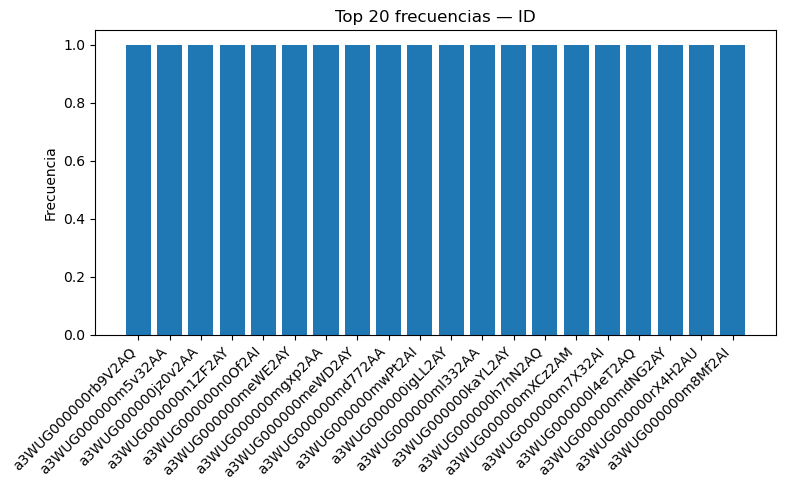

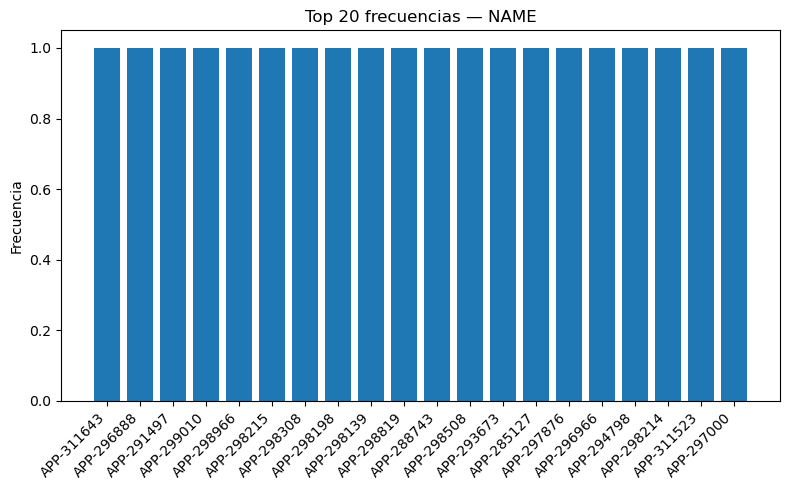

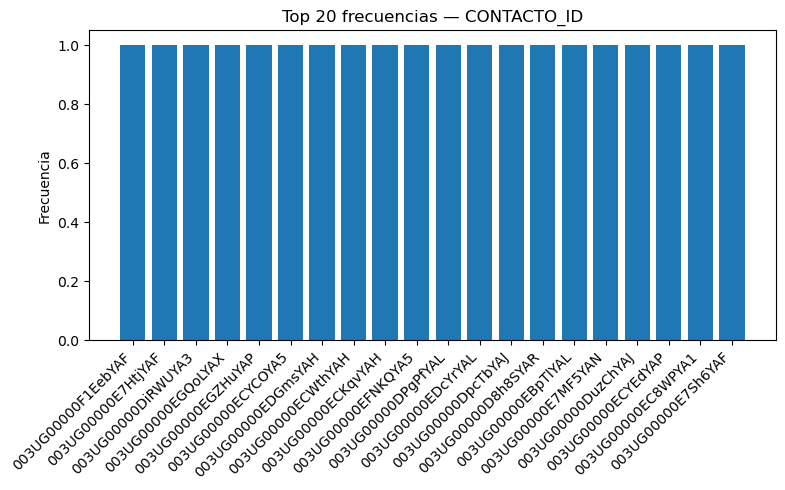

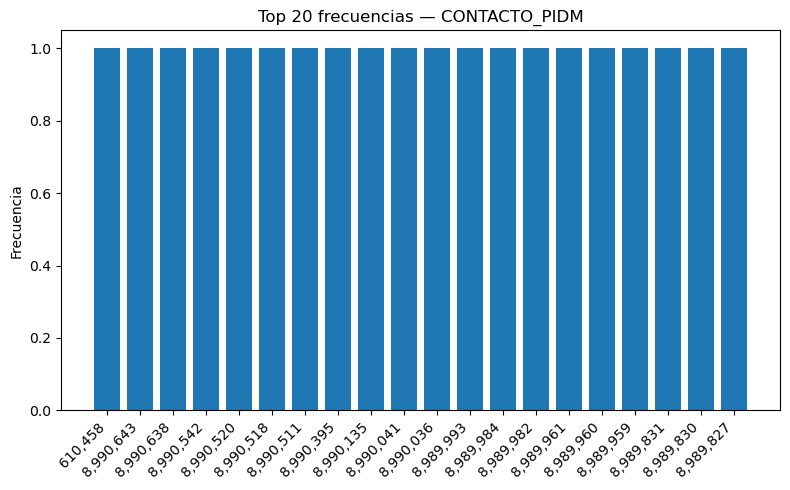

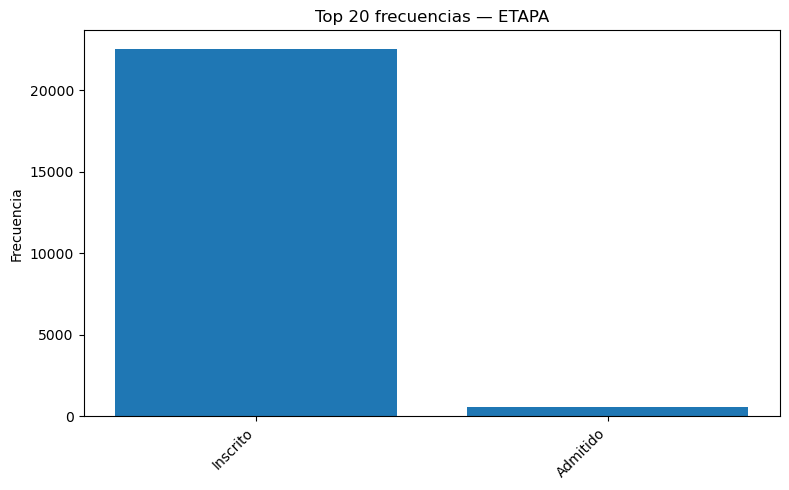

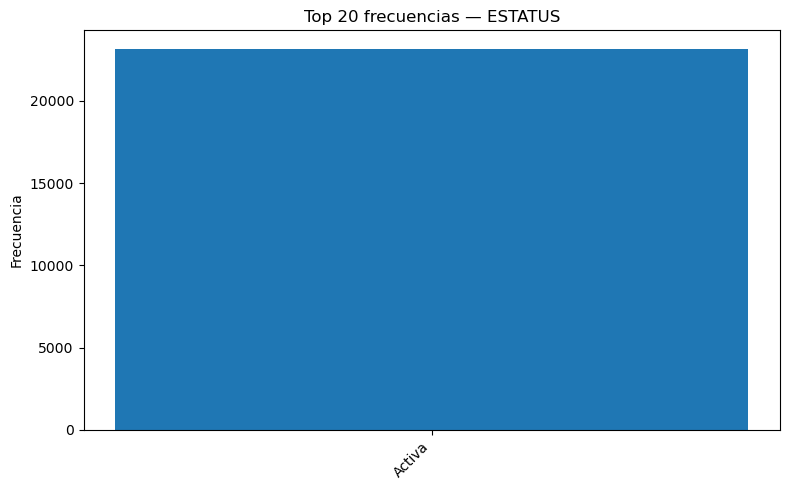

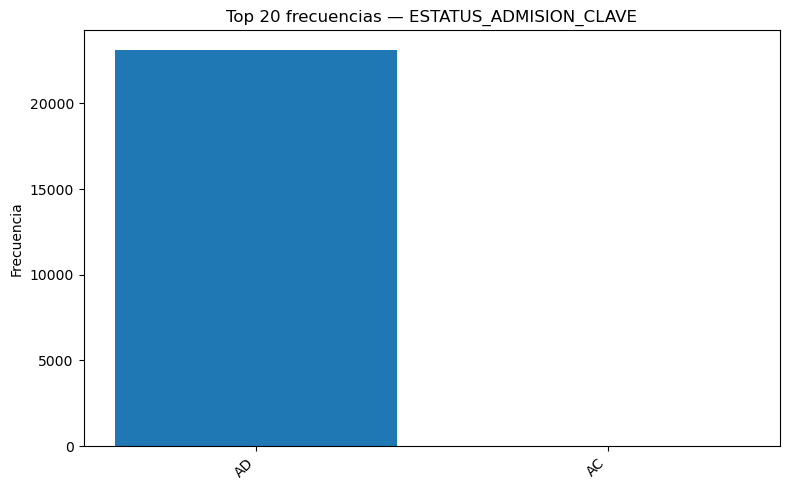

/var/folders/fl/wl49yz_52z7bbsgq3l31mqmr0000gn/T/ipykernel_99216/656720742.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


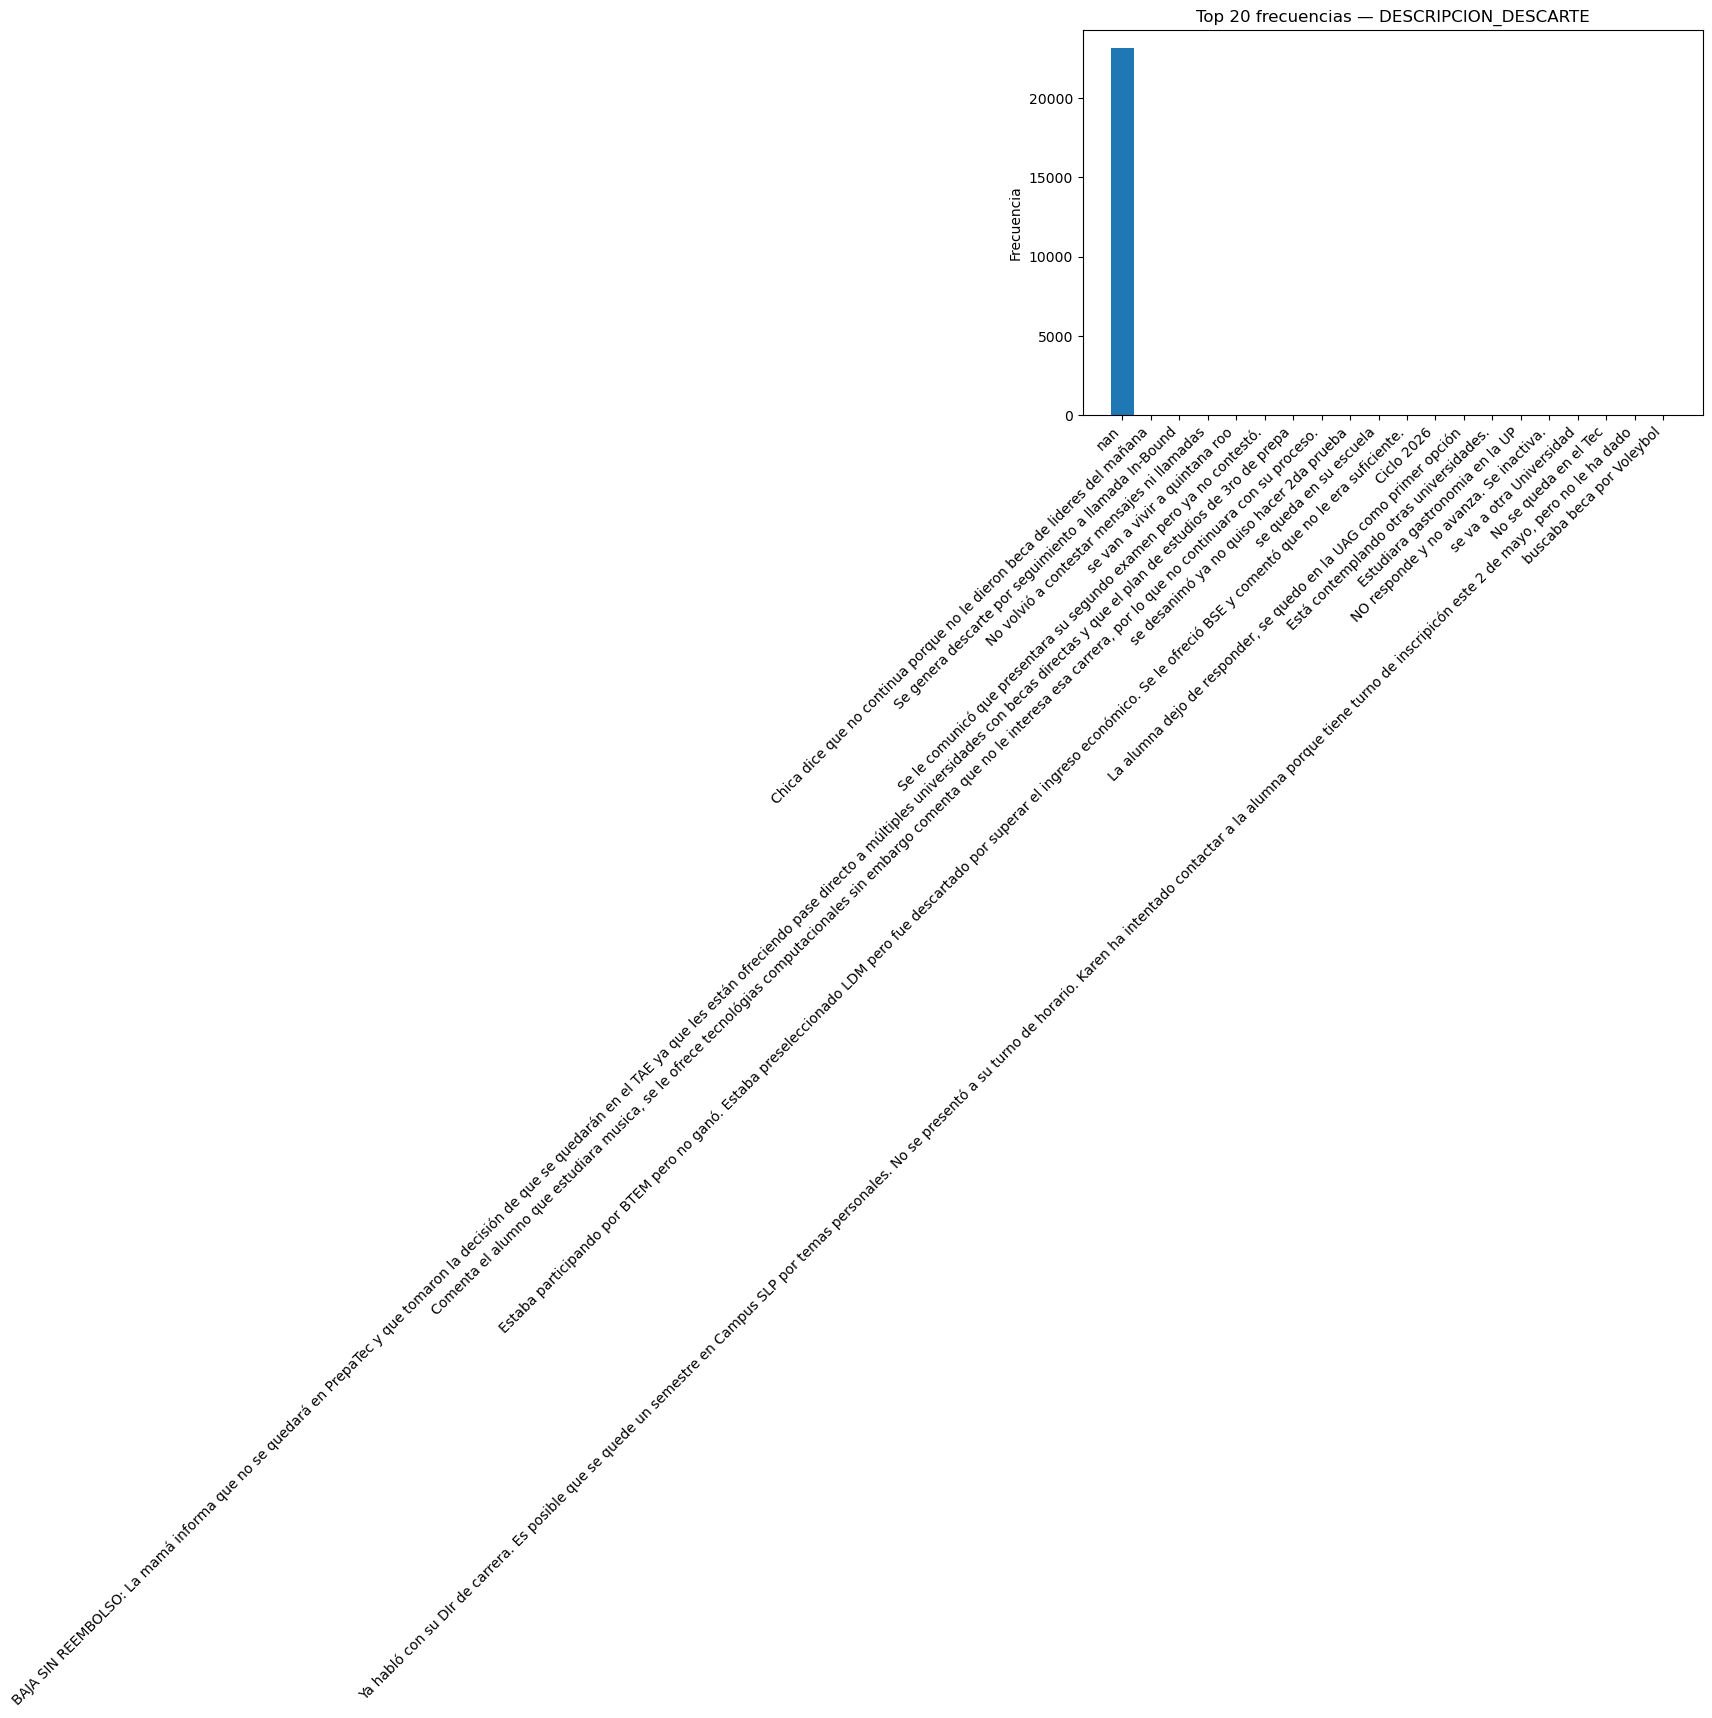

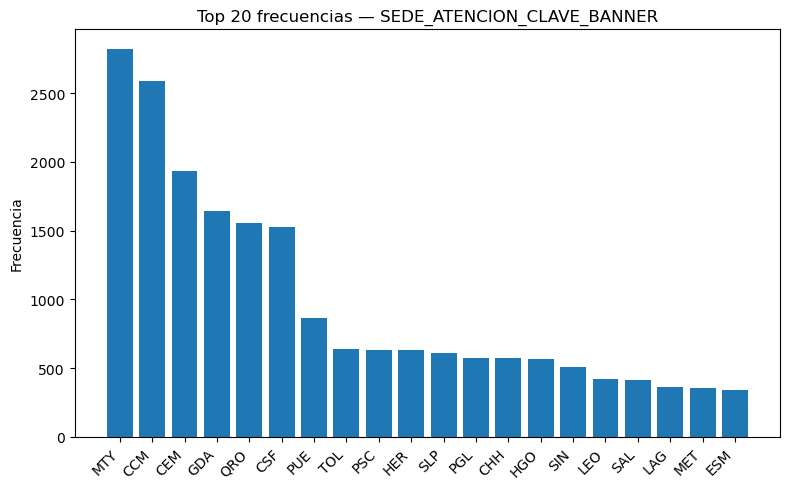

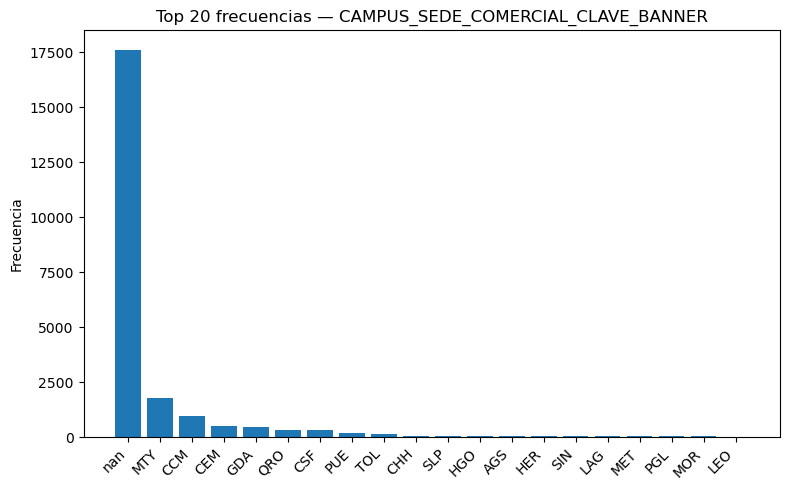

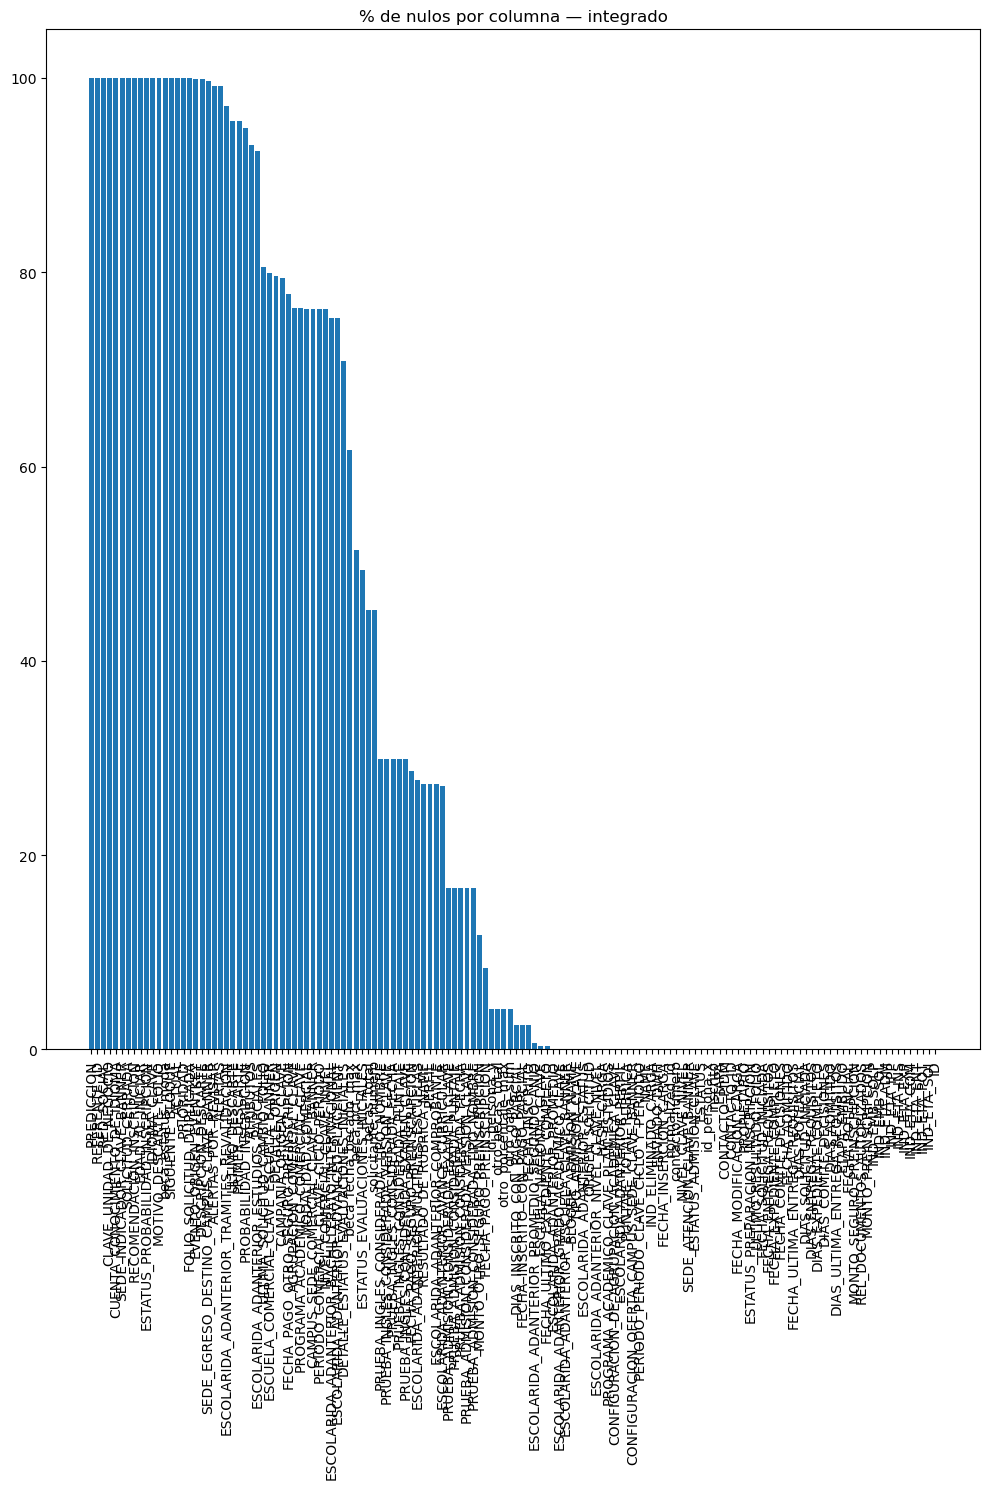

In [11]:
# === (1) Estructura de los datos ===
def describe_categoricas(df):
    desc = df.describe(include=["object"]).T
    na = df.isna().mean().rename("%nulos") * 100
    return desc.join(na, how="left")

if integrado is not None and len(integrado)>0:
    info_basica(integrado, "integrado")
    num_cols = integrado.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = [c for c in integrado.columns if c not in num_cols]

    if num_cols:
        display(integrado[num_cols].describe().T)
    if cat_cols:
        display(describe_categoricas(integrado[cat_cols]))
        for col in cat_cols[:TOP_N_CAT]:
            barras_frecuencias(integrado, col, top=20)

    nulos = (integrado.isna().mean()*100).sort_values(ascending=False)
    plt.figure(figsize=(10,15))
    plt.bar(range(len(nulos)), nulos.values)
    plt.xticks(range(len(nulos)), nulos.index, rotation=90)
    plt.title("% de nulos por columna — integrado")
    plt.tight_layout()
    plt.show()


## Análisis univariante

En esta etapa del EDA se examinan las variables **de manera individual** para comprender su distribución, rango de valores y comportamiento. Para las variables numéricas se emplean técnicas como histogramas y diagramas de caja (*boxplots*), que permiten identificar tendencias centrales, dispersión y posibles valores atípicos. En el caso de las variables categóricas, se analizan las frecuencias de cada categoría mediante tablas y gráficos de barras, lo que facilita detectar niveles dominantes, categorías poco representadas o problemas de alta cardinalidad. Este análisis constituye la base para entender el aporte potencial de cada variable al modelado posterior.


Sin datos para MOTIVO_DESCARTE_FOLIO
Sin datos para MOTIVO_DESCARTE_FOLIO


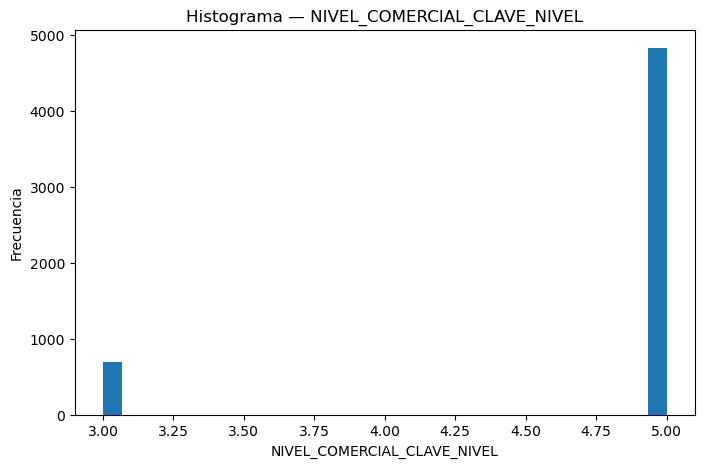

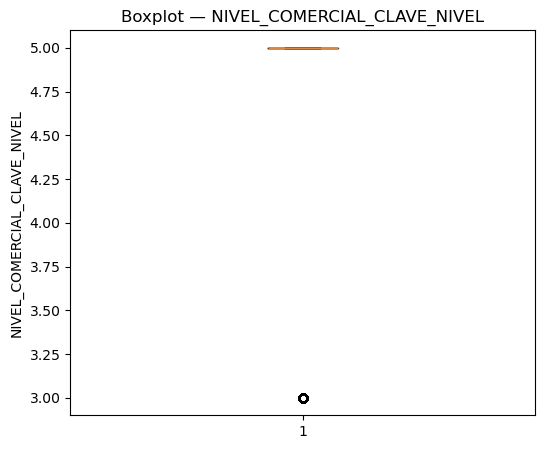

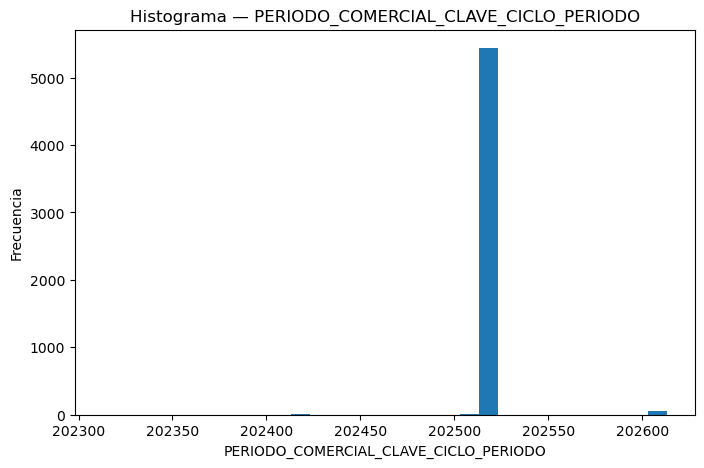

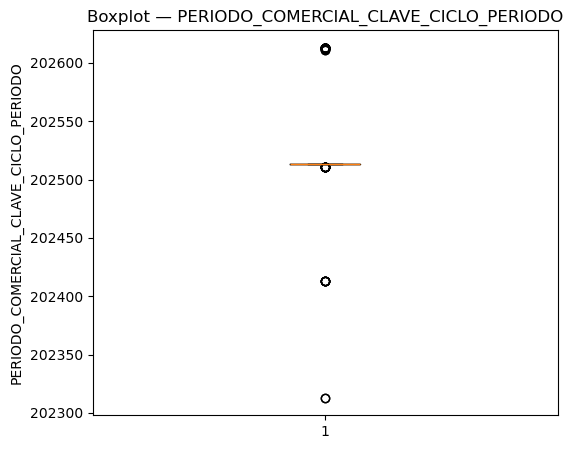

Sin datos para RED_SOCIAL
Sin datos para RED_SOCIAL
Sin datos para REFERENTE_ID
Sin datos para REFERENTE_ID


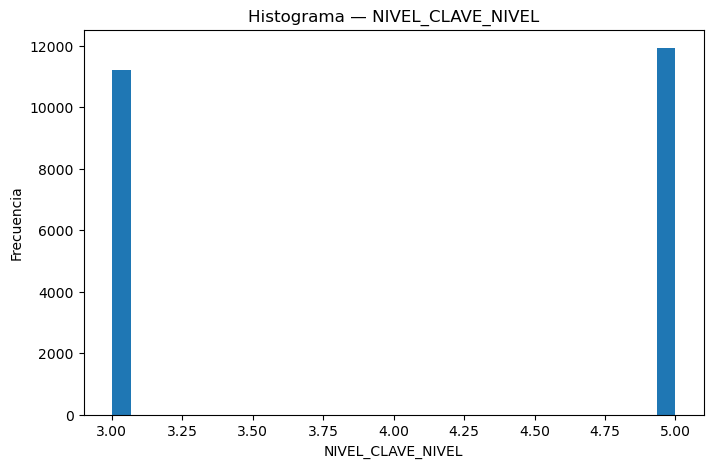

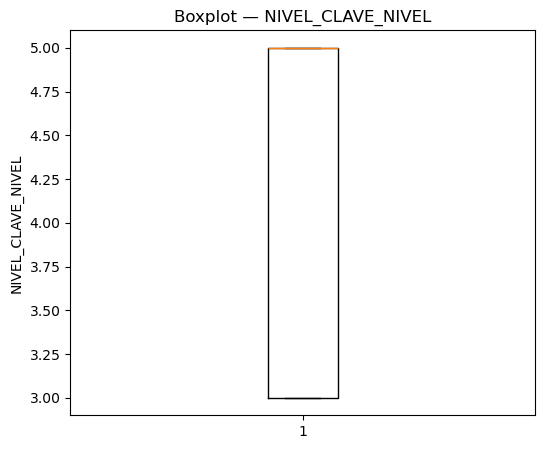

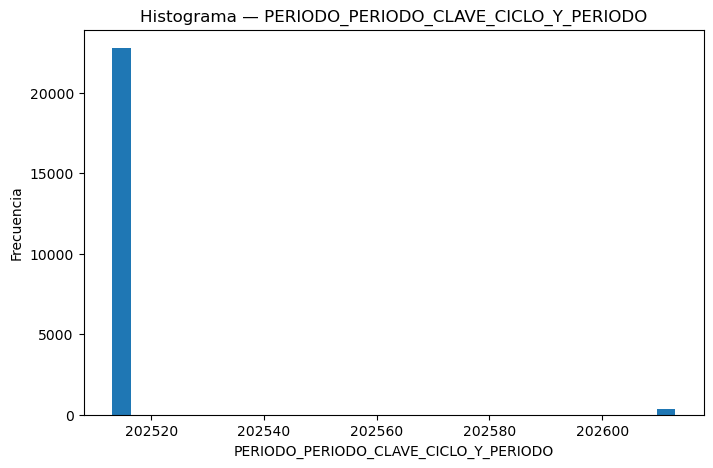

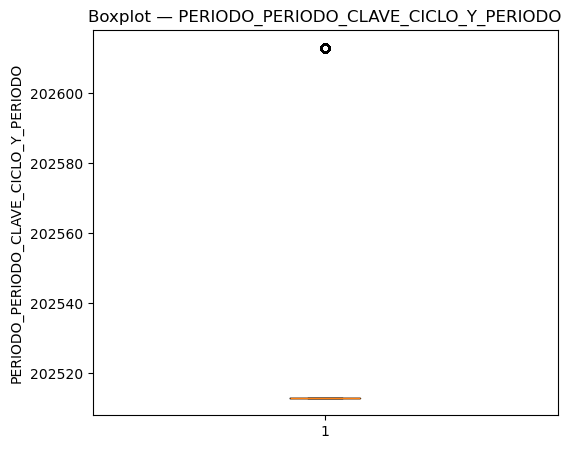

Sin datos para SEDE_INDICADOR_CLAVE_BANNER
Sin datos para SEDE_INDICADOR_CLAVE_BANNER


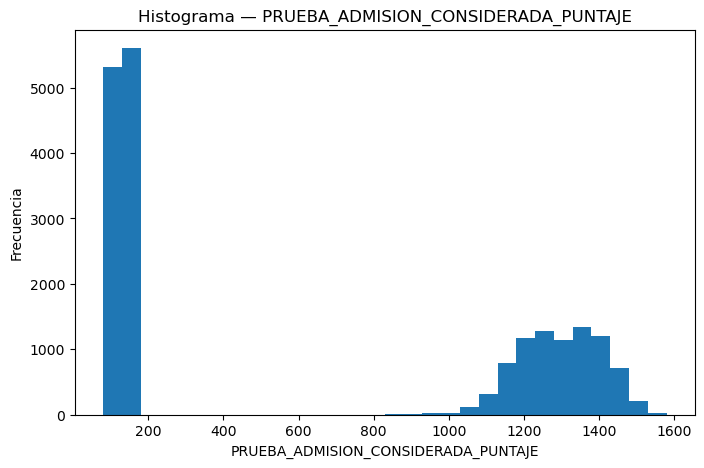

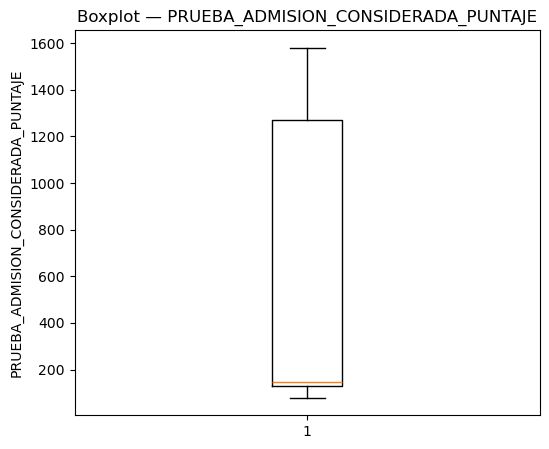

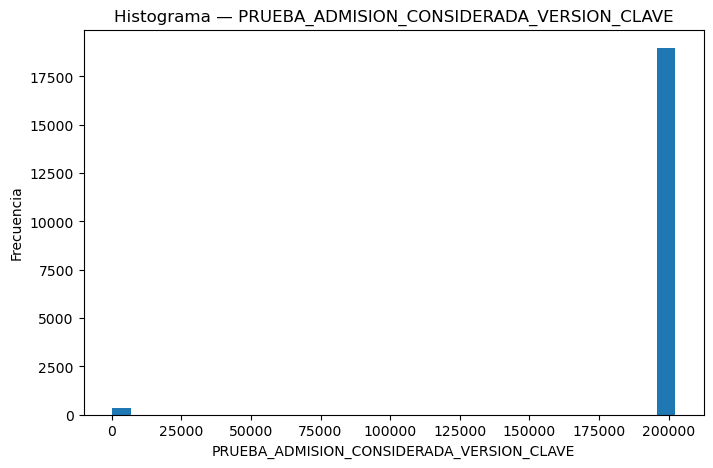

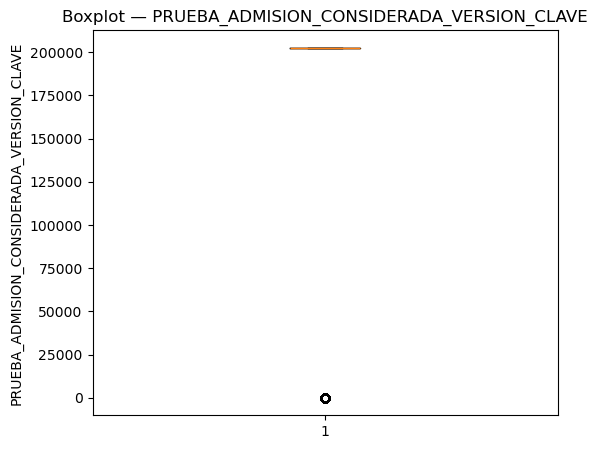

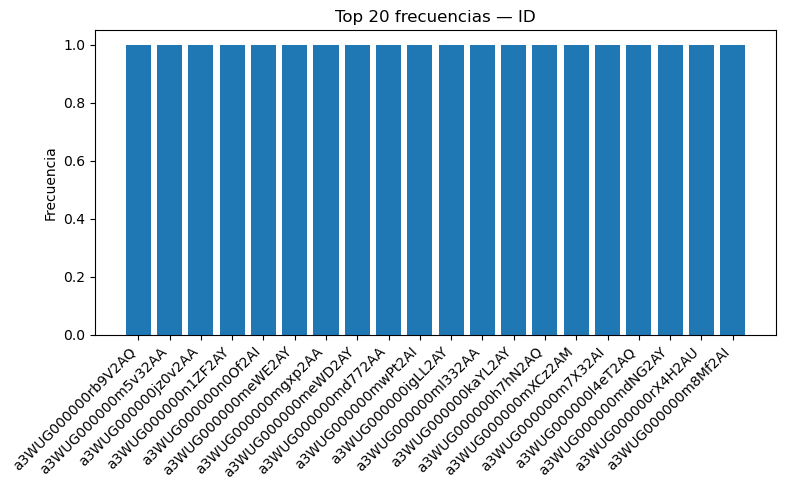

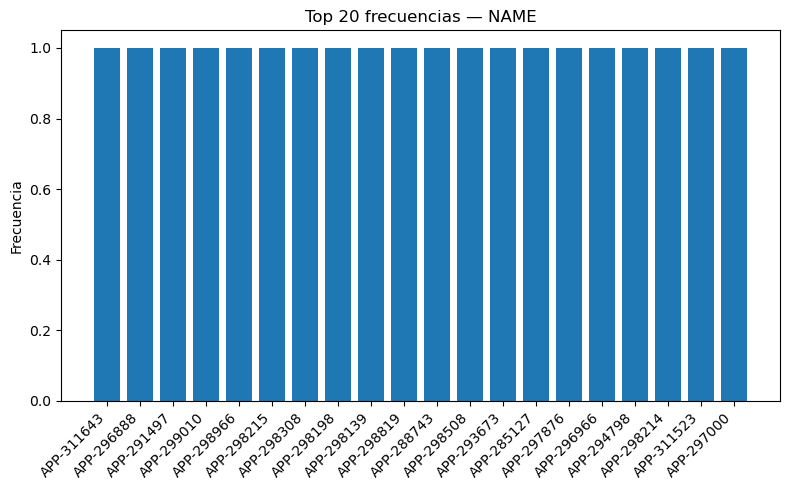

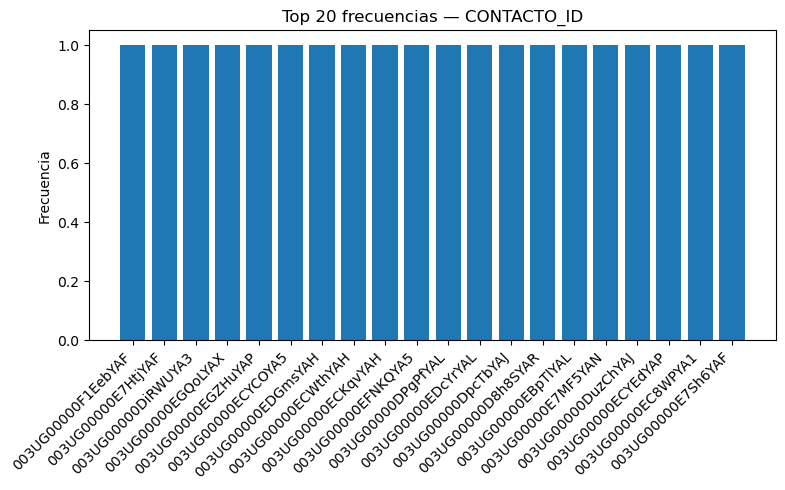

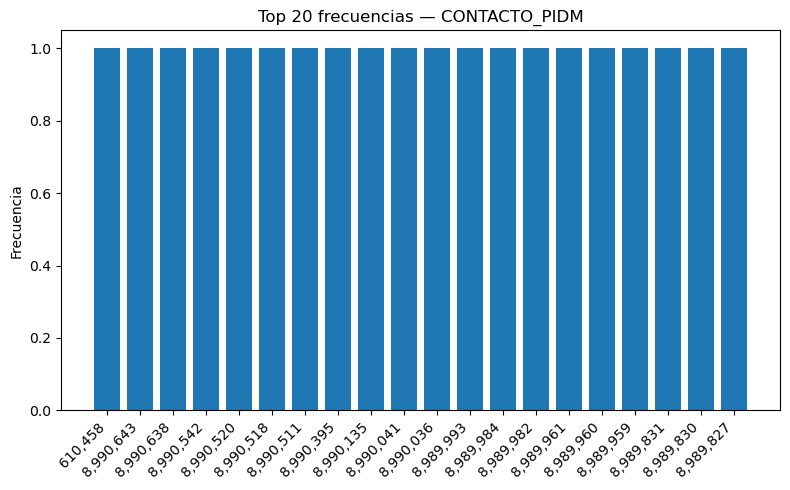

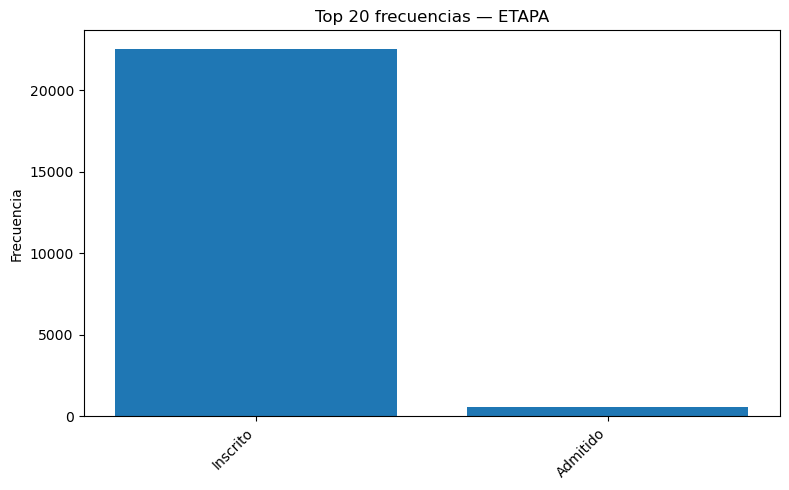

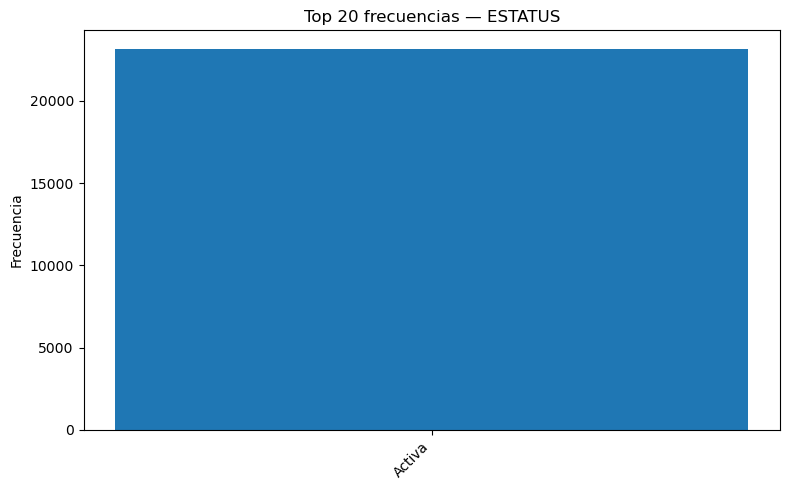

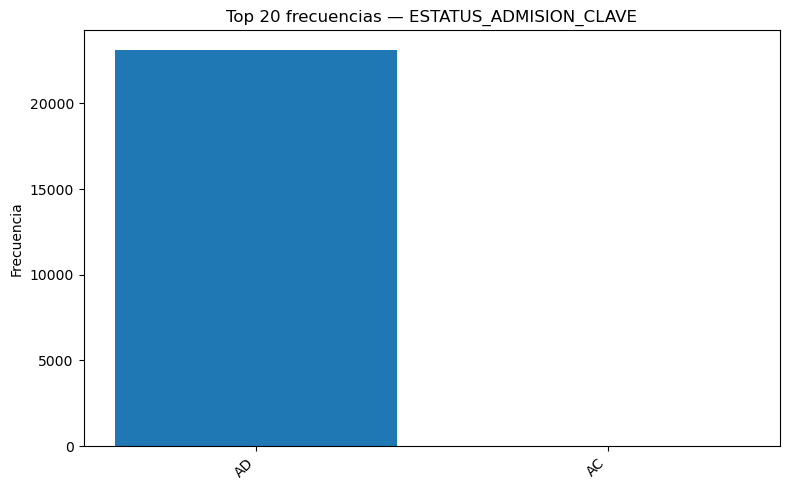

/var/folders/fl/wl49yz_52z7bbsgq3l31mqmr0000gn/T/ipykernel_99216/656720742.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


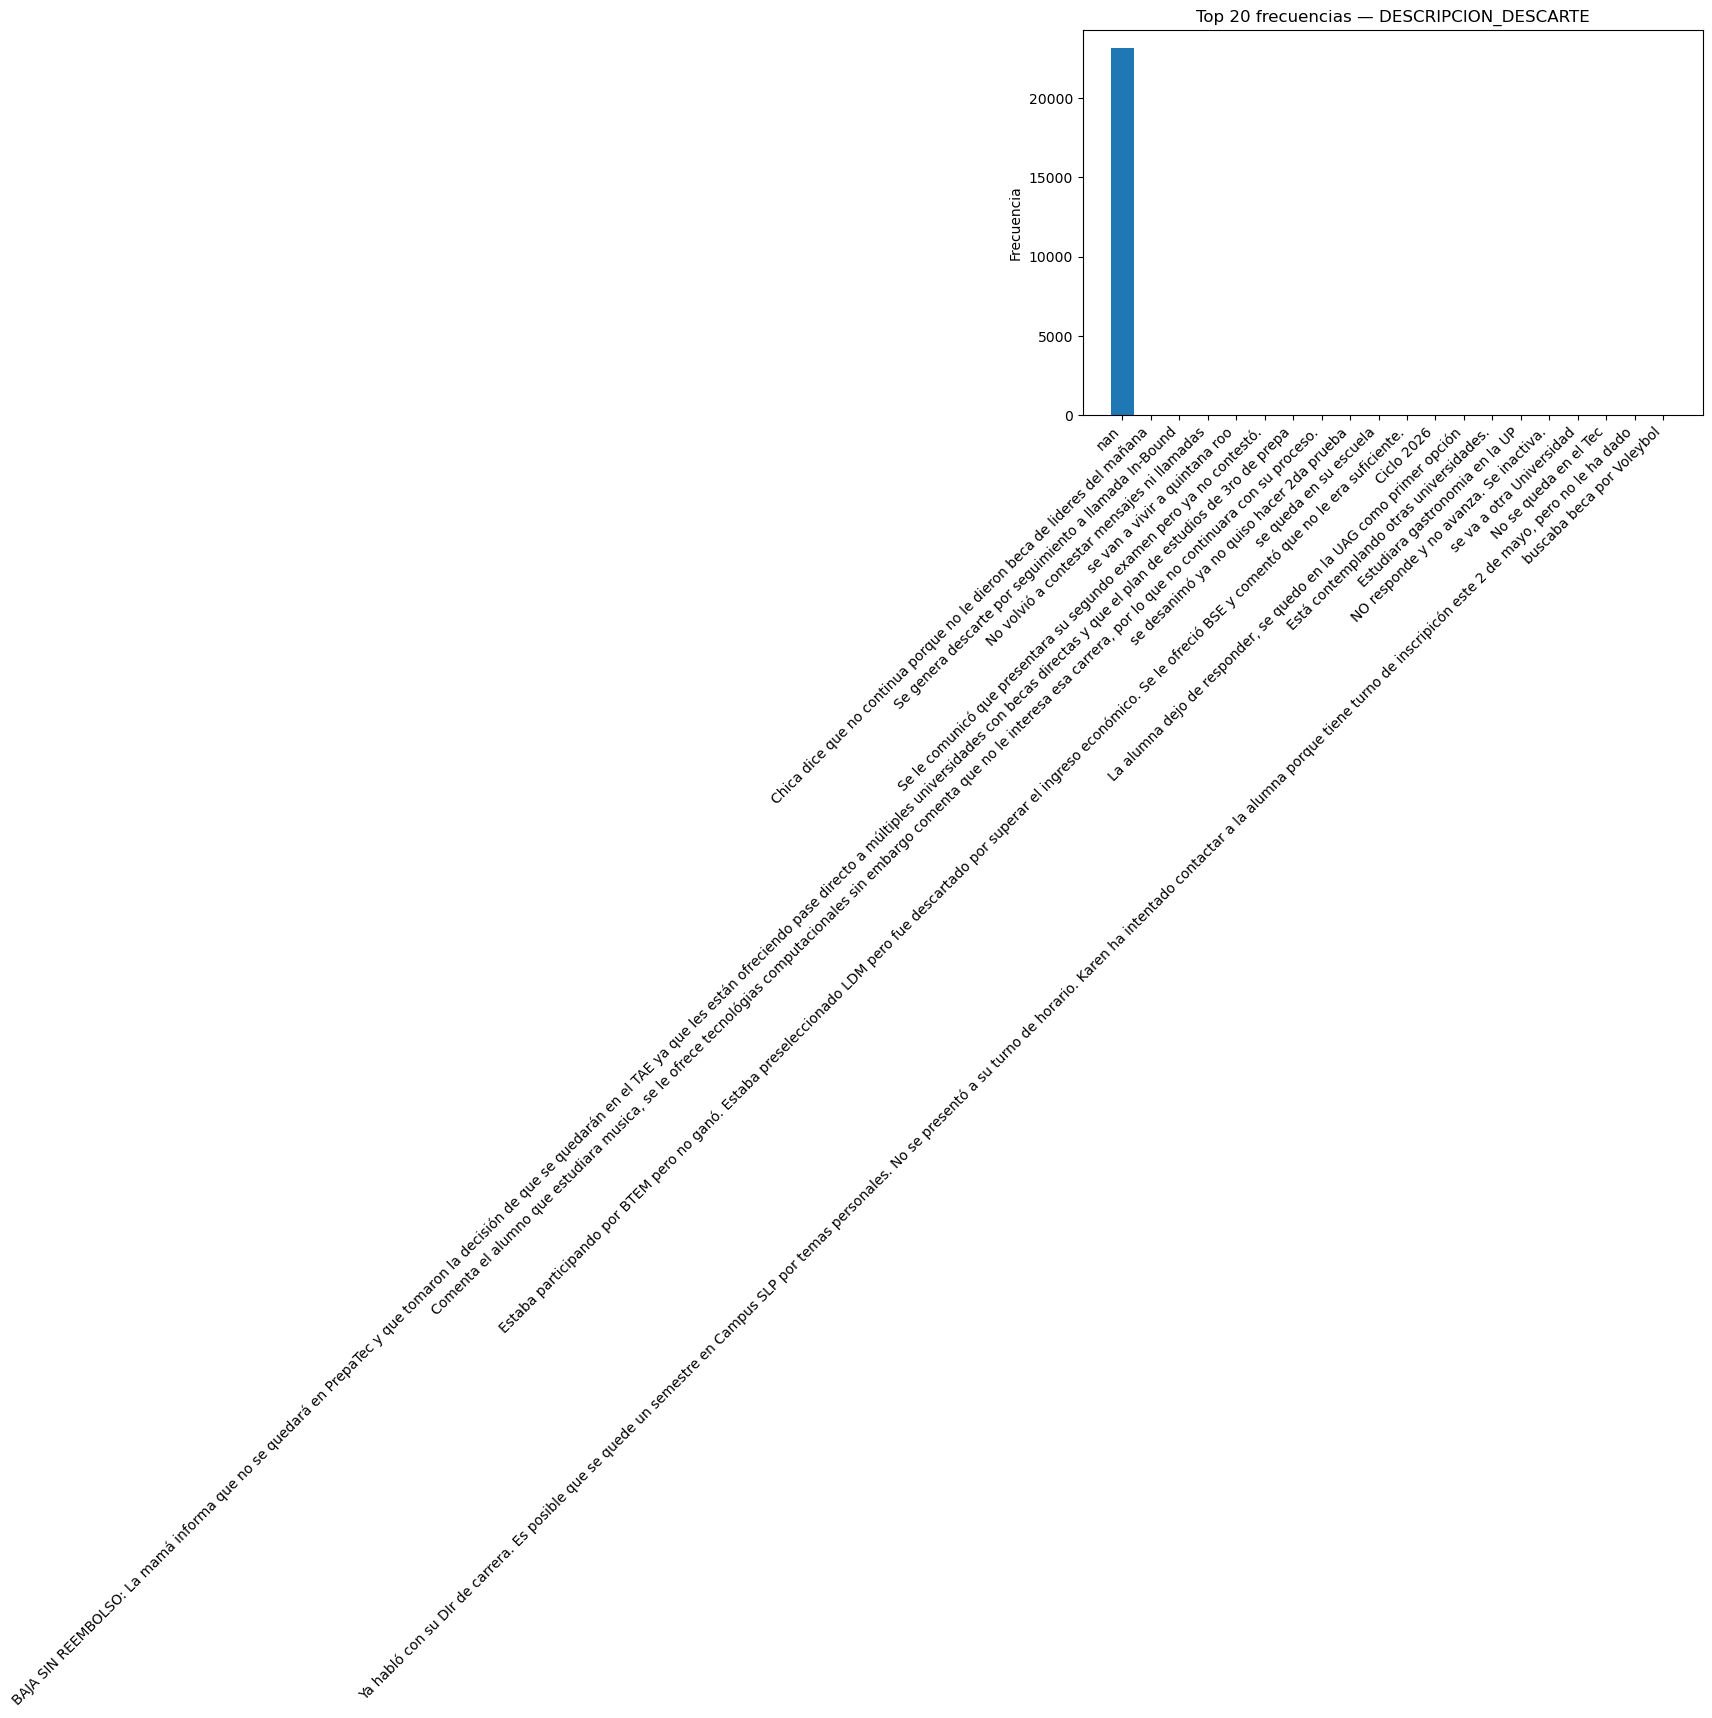

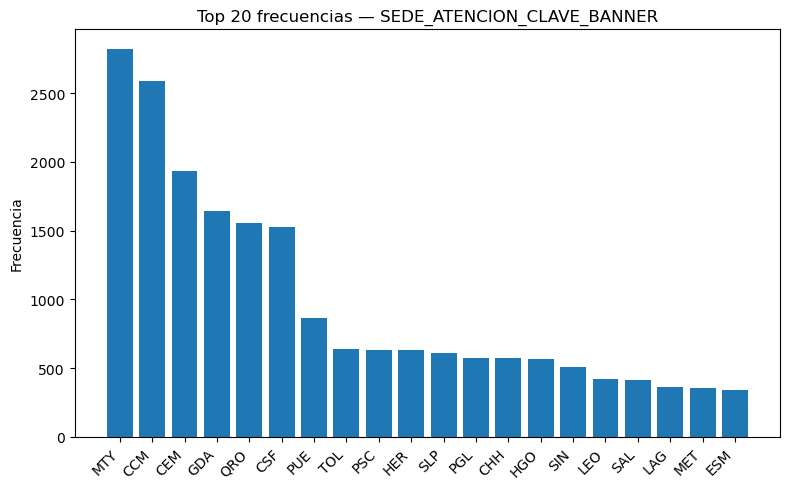

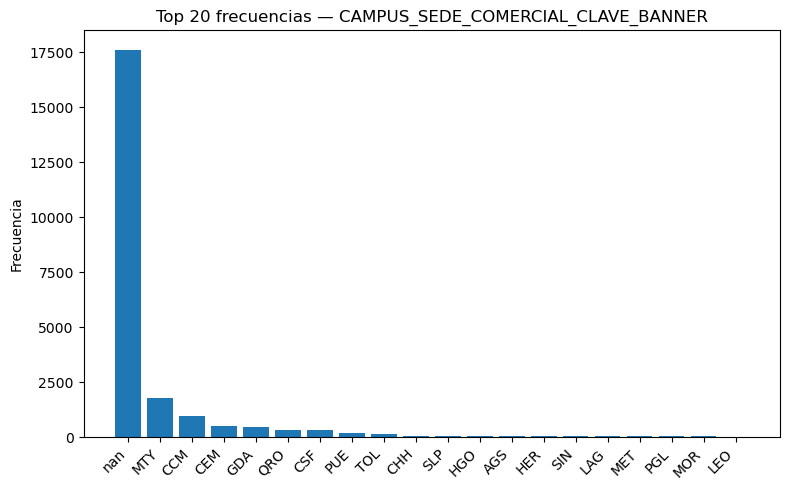

In [13]:
# === (2) Análisis univariante ===
if integrado is not None and len(integrado)>0:
    num_cols = integrado.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = [c for c in integrado.columns if c not in num_cols]

    for col in num_cols[:TOP_N_NUM]:
        histograma(integrado, col)
        boxplot(integrado, col)

    for col in cat_cols[:TOP_N_CAT]:
        barras_frecuencias(integrado, col, top=20)


## Análisis bivariado y multivariado

En esta fase del EDA se exploran las **relaciones entre pares de variables** (análisis bivariado) y entre múltiples variables simultáneamente (análisis multivariado). El objetivo es identificar patrones de asociación que no son evidentes en el análisis univariante. Para las variables numéricas se utilizan matrices de correlación y mapas de calor (*heatmaps*), que permiten detectar colinealidad o posibles predictores relevantes. En el caso de variables categóricas frente a la variable objetivo, se emplean tablas de contingencia y gráficos comparativos. Este análisis facilita comprender qué atributos tienen mayor poder explicativo sobre el fenómeno de interés y apoya la selección de variables en etapas posteriores de modelado.



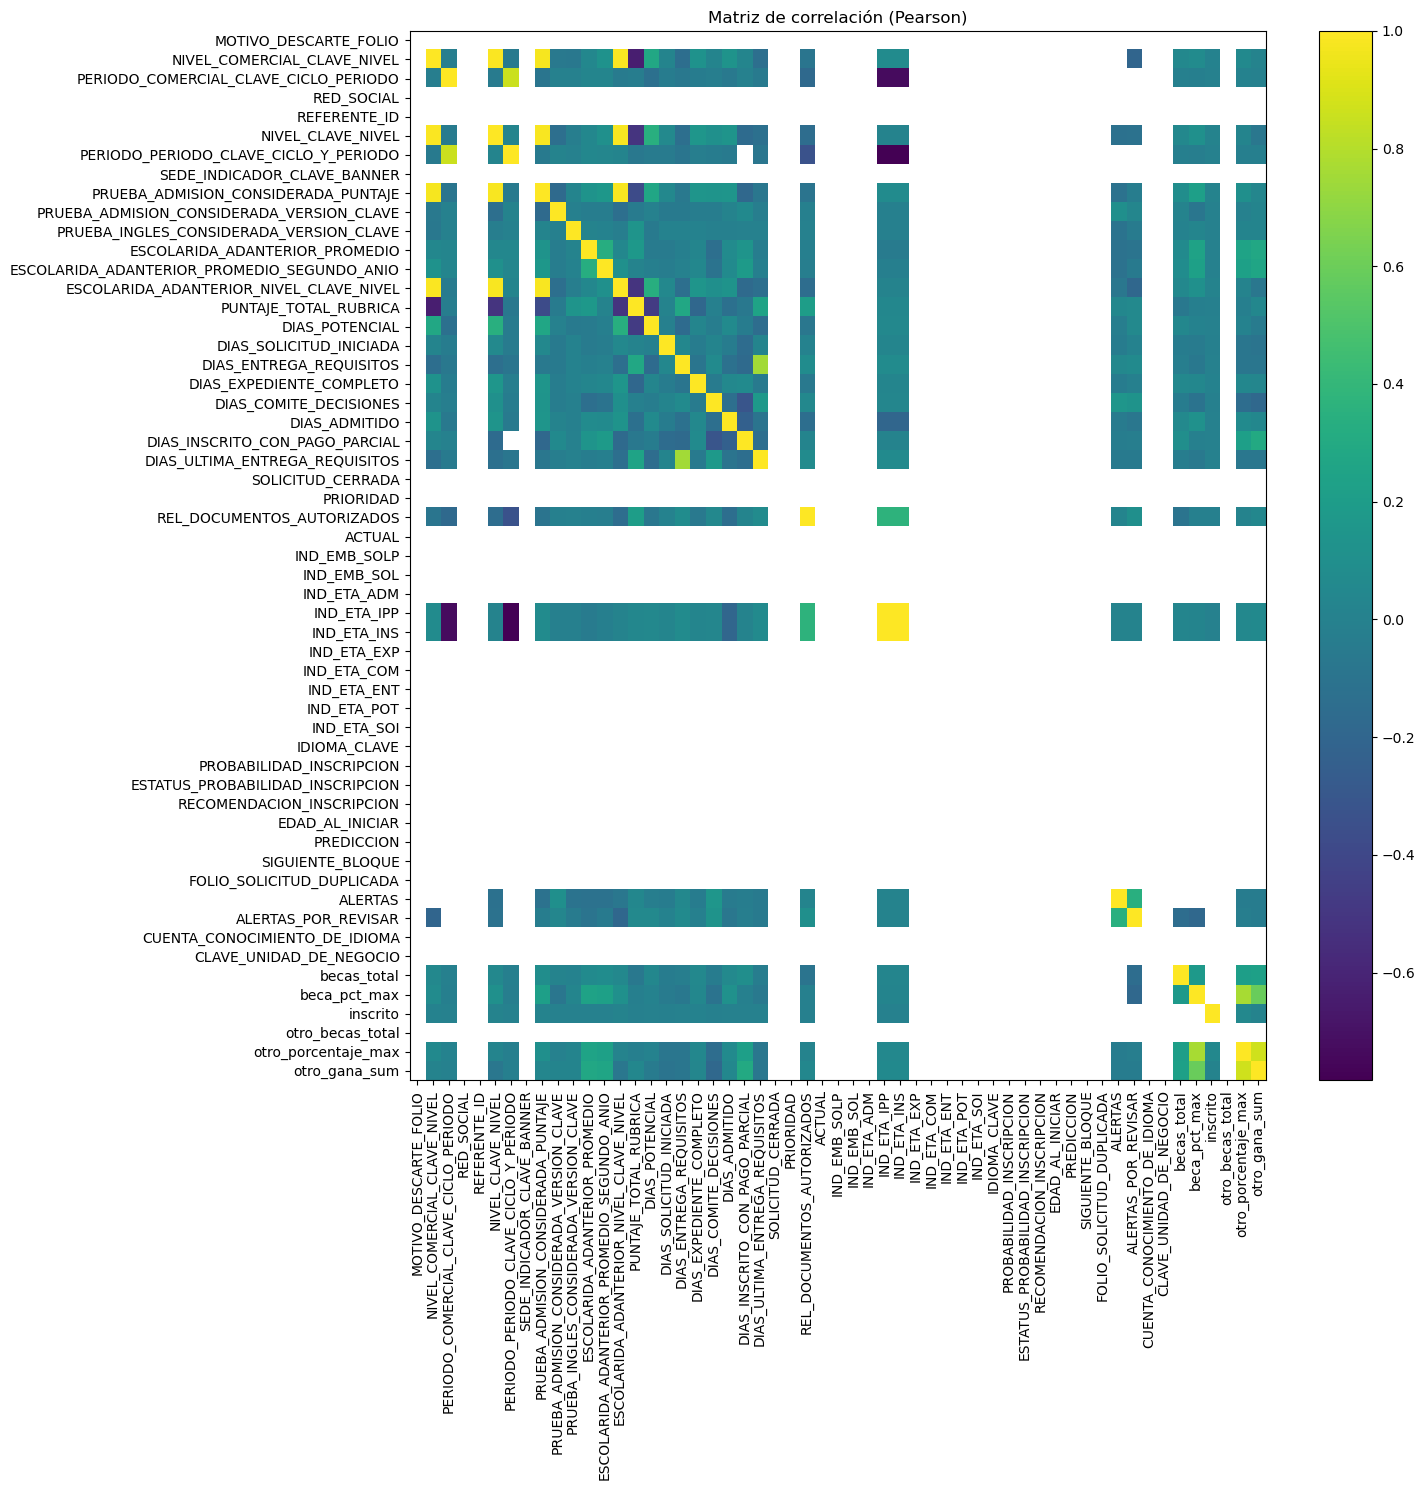

,MOTIVO_DESCARTE_FOLIO,NIVEL_COMERCIAL_CLAVE_NIVEL,PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,RED_SOCIAL,REFERENTE_ID,NIVEL_CLAVE_NIVEL,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO,SEDE_INDICADOR_CLAVE_BANNER,PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE,PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,ESCOLARIDA_ADANTERIOR_PROMEDIO,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL,PUNTAJE_TOTAL_RUBRICA,DIAS_POTENCIAL,DIAS_SOLICITUD_INICIADA,DIAS_ENTREGA_REQUISITOS,DIAS_EXPEDIENTE_COMPLETO,DIAS_COMITE_DECISIONES,DIAS_ADMITIDO,DIAS_INSCRITO_CON_PAGO_PARCIAL,DIAS_ULTIMA_ENTREGA_REQUISITOS,SOLICITUD_CERRADA,PRIORIDAD,REL_DOCUMENTOS_AUTORIZADOS,ACTUAL,IND_EMB_SOLP,IND_EMB_SOL,IND_ETA_ADM,IND_ETA_IPP,IND_ETA_INS,IND_ETA_EXP,IND_ETA_COM,IND_ETA_ENT,IND_ETA_POT,IND_ETA_SOI,IDIOMA_CLAVE,PROBABILIDAD_INSCRIPCION,ESTATUS_PROBABILIDAD_INSCRIPCION,RECOMENDACION_INSCRIPCION,EDAD_AL_INICIAR,PREDICCION,SIGUIENTE_BLOQUE,FOLIO_SOLICITUD_DUPLICADA,ALERTAS,ALERTAS_POR_REVISAR,CUENTA_CONOCIMIENTO_DE_IDIOMA,CLAVE_UNIDAD_DE_NEGOCIO,becas_total,beca_pct_max,inscrito,otro_becas_total,otro_porcentaje_max,otro_gana_sum
MOTIVO_DESCARTE_FOLIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIVEL_COMERCIAL_CLAVE_NIVEL,NaN,1.000000,-0.023567,NaN,NaN,0.990010,-0.049319,NaN,0.973594,-0.061937,-0.065767,0.041699,0.124358,0.990010,-0.633949,0.283828,0.023220,-0.141782,0.125084,0.021778,0.135418,0.026614,-0.129219,NaN,NaN,-0.091357,NaN,NaN,NaN,NaN,0.076651,0.076651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.200000,NaN,NaN,0.051692,0.078866,0.007195,NaN,0.064375,0.012045
PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,NaN,-0.023567,1.000000,NaN,NaN,-0.039181,0.858175,NaN,-0.092494,0.001961,-0.000223,0.028302,0.029983,-0.039181,-0.024015,-0.122966,-0.034446,-0.066956,-0.034418,-0.017061,-0.065448,0.003229,-0.052601,NaN,NaN,-0.170767,NaN,NaN,NaN,NaN,-0.731050,-0.731050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008096,-0.011853,-0.001301,NaN,0.008494,-0.001520
RED_SOCIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REFERENTE_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIVEL_CLAVE_NIVEL,NaN,0.990010,-0.039181,NaN,NaN,1.000000,0.020085,NaN,0.984246,-0.131778,-0.020382,0.044645,0.113381,0.983786,-0.517152,0.344970,0.054379,-0.128826,0.154691,0.110295,0.138708,-0.160822,-0.126507,NaN,NaN,-0.146776,NaN,NaN,NaN,NaN,0.017673,0.017673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.115787,-0.111479,NaN,NaN,0.052501,0.111929,0.015613,NaN,0.018567,-0.073707
PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO,NaN,-0.049319,0.858175,NaN,NaN,0.020085,1.000000,NaN,-0.056816,0.012604,0.002104,0.044741,0.034389,0.018554,-0.069981,-0.043950,-0.044598,-0.089847,-0.023792,-0.033340,-0.057425,NaN,-0.081628,NaN,NaN,-0.332511,NaN,NaN,NaN,NaN,-0.783191,-0.783191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011189,-0.017841,-0.002034,NaN,-0.010155,-0.012828
SEDE_INDICADOR_CLAVE_BANNER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,NaN,0.973594,-0.092494,NaN,NaN,0.984246,-0.056816,NaN,1.000000,-0.165792,0.018401,0.130602,0.160135,0.983017,-0.375161,0.269340,0.048048,-0.061397,0.146316,0.142439,0.143984,-0.177958,-0.078969,NaN,NaN,-0.096754,NaN,NaN,NaN,NaN,0.074234,0.07423

inscrito                                       1.000000
otro_porcentaje_max                            0.045837
otro_gana_sum                                  0.016728
NIVEL_CLAVE_NIVEL                              0.015613
ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL        0.015102
PRUEBA_ADMISION_CONSIDERADA_PUNTAJE            0.014931
DIAS_EXPEDIENTE_COMPLETO                       0.010143
NIVEL_COMERCIAL_CLAVE_NIVEL                    0.007195
ESCOLARIDA_ADANTERIOR_PROMEDIO                 0.003835
ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO    0.003750
IND_ETA_IPP                                    0.002596
IND_ETA_INS                                    0.002596
PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE        0.001673
PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE      0.001637
DIAS_POTENCIAL                                 0.001209
DIAS_ULTIMA_ENTREGA_REQUISITOS                 0.000557
DIAS_ENTREGA_REQUISITOS                        0.000370
DIAS_INSCRITO_CON_PAGO_PARCIAL                -0

In [15]:
# === (3) Análisis bi/multivariante  ===

# Columnas numéricas reales
num_cols = integrado.select_dtypes(include=["number"]).columns.tolist()

# 3.1 Correlación entre numéricas
if len(num_cols) >= 2:
    try:
        correlacion_heatmap(integrado[num_cols])
        display(integrado[num_cols].corr(numeric_only=True))
    except Exception as e:
        print(f"[Aviso] No se pudo graficar/mostrar la correlación numérica: {e}")
else:
    print("No hay suficientes columnas numéricas para correlación.")

# 3.2 Relaciones con TARGET (si se definió)
if TARGET and TARGET in integrado.columns:
    tgt = integrado[TARGET]

    # Caso TARGET numérica
    if pd.api.types.is_numeric_dtype(tgt):
        try:
            # Aseguramos que TARGET esté una sola vez
            cols_for_corr = list(dict.fromkeys(num_cols + [TARGET]))
            corr_mat = integrado[cols_for_corr].corr(numeric_only=True)
            if TARGET in corr_mat.columns:
                # corr_mat[TARGET] es una Serie → sort_values() sin 'by'
                corr_target = corr_mat[TARGET].sort_values(ascending=False)
                display(corr_target)
            else:
                print(f"[Aviso] {TARGET} no aparece en la matriz de correlación (posible varianza 0 o NaNs).")
        except Exception as e:
            print(f"[Aviso] No se pudo calcular correlación con {TARGET}: {e}")

    # Caso TARGET categórica
    else:
        cols_explorar = [c for c in integrado.columns if c != TARGET][:TOP_N_CAT]
        for col in cols_explorar:
            try:
                ct = pd.crosstab(integrado[col], tgt)
                display(ct.head(20))
            except Exception as e:
                print(f"[Aviso] No se pudo calcular contingencia {col} vs {TARGET}: {e}")


In [16]:
if integrado is not None and len(integrado)>0:
    falt = (integrado.isna().mean()*100).sort_values(ascending=False)
    display(falt.head(30))

    res = []
    num_cols = integrado.select_dtypes(include=["number"]).columns.tolist()
    for col in num_cols:
        s = integrado[col].dropna()
        if s.empty:
            continue
        iqr_mask = iqr_outlier_mask(s)
        mad_mask = mad_outlier_mask(s)
        res.append({
            "columna": col,
            "outliers_IQR": int(iqr_mask.sum()),
            "outliers_MAD": int(mad_mask.sum()),
            "pct_outliers_IQR": round(100*iqr_mask.mean(), 2),
            "pct_outliers_MAD": round(100*mad_mask.mean(), 2),
        })
    out_df = pd.DataFrame(res).sort_values(by="pct_outliers_IQR", ascending=False)
    display(out_df.head(30))

    cat_cols = [c for c in integrado.columns if c not in num_cols]
    if cat_cols:
        card = integrado[cat_cols].nunique().sort_values(ascending=False)
        display(card.head(30))


PREDICCION                                     100.000000
REFERENTE_ID                                   100.000000
RED_SOCIAL                                     100.000000
CLAVE_UNIDAD_DE_NEGOCIO                        100.000000
CUENTA_CONOCIMIENTO_DE_IDIOMA                  100.000000
SEDE_INDICADOR_CLAVE_BANNER                    100.000000
SOLICITUD_CERRADA                              100.000000
RECOMENDACION_INSCRIPCION                      100.000000
EDAD_AL_INICIAR                                100.000000
ESTATUS_PROBABILIDAD_INSCRIPCION               100.000000
IDIOMA_CLAVE                                   100.000000
MOTIVO_DESCARTE_FOLIO                          100.000000
beca_estatus_moda                              100.000000
SIGUIENTE_BLOQUE                               100.000000
ACTUAL                                         100.000000
PRIORIDAD                                      100.000000
FOLIO_SOLICITUD_DUPLICADA                      100.000000
EVENTO_ORIGEN_

,columna,outliers_IQR,outliers_MAD,pct_outliers_IQR,pct_outliers_MAD
15,DIAS_COMITE_DECISIONES,5871,5172,25.38,22.36
11,DIAS_POTENCIAL,4990,0,21.57,0.00
12,DIAS_SOLICITUD_INICIADA,2641,4930,11.42,21.31
16,DIAS_ADMITIDO,2640,3089,11.41,13.35
14,DIAS_EXPEDIENTE_COMPLETO,2039,1893,8.81,8.18
18,DIAS_ULTIMA_ENTREGA_REQUISITOS,968,798,4.18,3.45
13,DIAS_ENTREGA_REQUISITOS,870,711,3.76,3.07
37,otro_porcentaje_max,507,0,2.29,0.00
8,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,449,448,1.95,1.95
5,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE,334,8387,1.73,43.45


ID                                            23135
NAME                                          23135
CONTACTO_ID                                   23135
CONTACTO_PIDM                                 23135
id_persona_x                                  23135
contacto_numero                               23135
normalized_id                                 23135
HASH_CARGA                                    23135
ULTIMO_RESULTADO_FOLIO                        23135
id_persona_y                                  22166
solicitante_numero                            12670
ULTIMA_SOLICITUD_CAMBIO_FOLIO                  4506
ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER     4144
FECHA_POTENCIAL                                 552
PROPIETARIO                                     539
FECHA_ENTREGA_REQUISITOS                        432
FECHA_ULTIMA_ENTREGA_REQUISITOS                 432
FECHA_SOLICITUD_INICIADA                        432
PRUEBA_INGLES_CONSIDERADA_FECHA                 405
FECHA_EXPEDI

In [17]:
integrado.shape

(23135, 138)

## Reducción de variables

Luego de analizar las características de los atributos mediante gráficas, estadísticas descriptivas y matrices de correlación, se decidió **remover 47 columnas**, quedando un total de **91 columnas** en el conjunto de datos final.

### Identificadores únicos
Se eliminaron todos los campos referentes a identificadores redundantes, dejando únicamente **`contacto_numero`** como identificador único de cada registro:

- `id_persona`  
- `NAME`  
- `CONTACTO_ID`  
- `solicitante_numero`  
- `id_persona_x`  
- `id_persona_y`  
- `ULTIMO_RESULTADO_FOLIO`  
- `ULTIMA_SOLICITUD_CAMBIO_FOLIO`  
- `HASH_CARGA`  
- `normalized_id`  

### Otras columnas eliminadas y justificación

- **`CONTACTO_PIDM`**: Información no relevante.  
- **`ESTATUS`**: Todos los registros tienen el mismo valor.  
- **`MOTIVO_DESCARTE_FOLIO`**: Sin valores.  
- **`DESCRIPCION_DESCARTE`**: Solo 21 valores; sin aporte significativo.  
- **`MODALIDAD_COMERCIAL`**: Mayoría vacíos; resto ≈5k con valor "Presencial".  
- **`RED_SOCIAL`**: Vacío.  
- **`EVENTO_ORIGEN_EVENTKEY`**: Solo 19 registros con valor.  
- **`REFERENTE_ID`**: Vacío.  
- **`SEDE_INDICADOR_CLAVE_BANNER`**: Vacío.  
- **`SEDE_EGRESO_DESTINO_CAMPUS_CLAVE_BANNER`**: Solo 70 registros con valor; poca utilidad.  
- **`PRIORIDAD`**: Vacío.  
- **`ACTUAL`**: Vacío.  
- **`IND_EMB_SOLP`, `IND_EMB_SOL`, `IND_ETA_ADM`, `IND_ETA_EXP`, `IND_ETA_COM`, `IND_ETA_ENT`, `IND_ETA_POT`, `IND_ETA_SOI`**: Todos con el mismo valor.  
- **`IDIOMA_CLAVE`**: Vacío.  
- **`PROBABILIDAD_INSCRIPCION`**: Solo valores de 0 y vacíos.  
- **`ESTATUS_PROBABILIDAD_INSCRIPCION`**: Vacío.  
- **`RECOMENDACION_INSCRIPCION`**: Vacío.  
- **`EDAD_AL_INICIAR`**: Vacío.  
- **`PREDICCION`**: Vacío.  
- **`SIGUIENTE_BLOQUE`**: Vacío.  
- **`FOLIO_SOLICITUD_DUPLICADA`**: Vacío.  
- **`ALERTAS`**: Muy desbalanceado; 192 valores = 1, 1 valor = 2, resto vacíos.  
- **`ALERTAS_POR_REVISAR`**: Tres categorías desbalanceadas y poco pobladas.  
- **`CUENTA_CONOCIMIENTO_DE_IDIOMA`**: Vacío.  
- **`CLAVE_UNIDAD_DE_NEGOCIO`**: Vacío.  
- **`IND_ELIMINADO_CARGA`**: Un solo valor.  
- **`ENVIADO_DWH`**: Un solo valor.  
- **`beca_estatus_moda`**: Vacío.  
- **`SOLICITUD_CERRADA`**: Vacío.  
- **`ETAPA`**: Información duplicada con la columna `ETAPA_EMBUDO`.  



In [19]:
columnas_a_eliminar = [
    "ID",
    "NAME",
    "CONTACTO_ID",
    "solicitante_numero",
    "id_persona_x",
    "id_persona_y",
    "ULTIMO_RESULTADO_FOLIO",
    "ULTIMA_SOLICITUD_CAMBIO_FOLIO",
    "HASH_CARGA",
    "normalized_id",
    "CONTACTO_PIDM",
    "ESTATUS",
    "MOTIVO_DESCARTE_FOLIO",
    "DESCRIPCION_DESCARTE",
    "MODALIDAD_COMERCIAL",
    "RED_SOCIAL",
    "EVENTO_ORIGEN_EVENTKEY",
    "REFERENTE_ID",
    "SEDE_INDICADOR_CLAVE_BANNER",
    "SEDE_EGRESO_DESTINO_CAMPUS_CLAVE_BANNER",
    "PRIORIDAD",
    "ACTUAL",
    "IND_EMB_SOLP",
    "IND_EMB_SOL",
    "IND_ETA_ADM",
    "IND_ETA_EXP",
    "IND_ETA_COM",
    "IND_ETA_ENT",
    "IND_ETA_POT",
    "IND_ETA_SOI",
    "IDIOMA_CLAVE",
    "PROBABILIDAD_INSCRIPCION",
    "ESTATUS_PROBABILIDAD_INSCRIPCION",
    "RECOMENDACION_INSCRIPCION",
    "EDAD_AL_INICIAR",
    "PREDICCION",
    "SIGUIENTE_BLOQUE",
    "FOLIO_SOLICITUD_DUPLICADA",
    "ALERTAS",
    "ALERTAS_POR_REVISAR",
    "CUENTA_CONOCIMIENTO_DE_IDIOMA",
    "CLAVE_UNIDAD_DE_NEGOCIO",
    "IND_ELIMINADO_CARGA",
    "ENVIADO_DWH",
    "beca_estatus_moda",
    "ETAPA","SOLICITUD_CERRADA"
]

# Eliminar las columnas
integrado = integrado.drop(columns=columnas_a_eliminar)

print("Columnas eliminadas correctamente. Nuevo dataframe con forma:", integrado.shape)


Columnas eliminadas correctamente. Nuevo dataframe con forma: (23135, 91)


In [20]:
pd.reset_option('display.max_rows')

In [21]:
integrado

,ESTATUS_ADMISION_CLAVE,SEDE_ATENCION_CLAVE_BANNER,NIVEL_COMERCIAL_CLAVE_NIVEL,PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,CAMPUS_SEDE_COMERCIAL_CLAVE_BANNER,AGRUPACION_COMERCIAL_CLAVE,PROGRAMA_ACADEMICO_COMERCIAL_CLAVE,ORIGEN_SOLICITUD,DETALLE_ORIGEN,CAMPANIA_ORIGEN_CLAVE,ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER,NIVEL_CLAVE_NIVEL,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO,CONFIGURACION_OFERTA_CAMPUS_SEDE_CLAVE_BANNER,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE,PROGRAMA_ACADEMICO_CLAVE_PLAN_ESTUDIOS,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE,PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,PRUEBA_ADMISION_CONSIDERADA_FECHA,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE,PRUEBA_INGLES_CONSIDERADA_PUNTAJE,PRUEBA_INGLES_CONSIDERADA_FECHA,PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE,ESCOLARIDA_ADANTERIOR_PROMEDIO,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL,ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE,ESCOLARIDA_ADANTERIOR_ESTATUS,ESCOLARIDA_ADANTERIOR_PERFIL,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS,ESCOLARIDA_ADANTERIOR_COMPROBANTE,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION,PUNTAJE_TOTAL_RUBRICA,PERFIL,RESULTADO_DE_RUBRICA_NAME,BLOQUE_ADMISION_NAME,TIPO_ADMISION_CLAVE,ATRIBUTOS,MONTO_PREINSCRIPCION,FECHA_PAGO_PREINSCRIPCION,MONTO_SEGURO_PREINSCRIPCION,FECHA_PAGO_SEGURO_PREINSCRIPCION,MONTO_OTRO_SEGURO_PREINSCRIPCION,FECHA_PAGO_OTRO_SEGURO_PREINSCRIPCION,ESTATUS_EVALUACIONES_INICIALES,DETALLE_ESTATUS_EVALUACIONES_INICIALES,FECHA_POTENCIAL,FECHA_SOLICITUD_INICIADA,FECHA_ENTREGA_REQUISITOS,FECHA_EXPEDIENTE_COMPLETO,FECHA_COMITE_DECISIONES,FECHA_ADMITIDO,FECHA_INSCRITO_CON_PAGO_PARCIAL,FECHA_INSCRITO,FECHA_ULTIMA_ENTREGA_REQUISITOS,FECHA_ULTIMO_EXPEDIENTE_COMPLETO,DIAS_POTENCIAL,DIAS_SOLICITUD_INICIADA,DIAS_ENTREGA_REQUISITOS,DIAS_EXPEDIENTE_COMPLETO,DIAS_COMITE_DECISIONES,DIAS_ADMITIDO,DIAS_INSCRITO_CON_PAGO_PARCIAL,DIAS_ULTIMA_ENTREGA_REQUISITOS,ETAPA_EMBUDO,REL_DOCUMENTOS_AUTORIZADOS,IND_ETA_IPP,IND_ETA_INS,PROPIETARIO,ESCUELA_NACIONAL_CLAVE,ESTATUS_PREPARACION_INSCRIPCION,PRIMER_DESCARTE,ULTIMO_DESCARTE,FECHA_INSERCION_CARGA,FECHA_MODIFICACION_CARGA,contacto_numero,becas_total,beca_pct_max,beca_fecha_becado_max,inscrito,otro_becas_total,otro_porcentaje_max,otro_gana_sum
0,AD,MTY,NaN,NaN,NaN,NaN,NaN,Solicitud,NaN,NaN,NaN,5,202513,MTY,SLD,LNB19,E03T,1342.0,2024-11-30T00:00:00.000Z,202417.0,G4,NaN,NaN,NaN,NaN,NaN,84.0,NaN,5,C00001,IIA07,T,Tec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,Entrega 15,M5,NaN,"7,110",2025-01-23T00:00:00.000Z,"-1,890",2025-05-22T00:00:00.000Z,NaN,NaN,Completas,NaN,2024-10-23 00:00:00+00:00,2024-10-23 00:00:00+00:00,2024-10-29 00:00:00+00:00,2024-02-12 00:00:00+00:00,2024-04-12 00:00:00+00:00,2025-01-22 00:00:00+00:00,2025-05-16 00:00:00+00:00,2025-11-06 00:00:00+00:00,2024-12-12 00:00:00+00:00,2025-01-14 00:00:00+00:00,0,6,34,2,49,114,26.0,33,Inscrito,100,1,1,0052M000008JYtwQAG,CS,Listo,NaN,NaN,2024-11-13 00:00:00+00:00,2025-02-09 00:00:00+00:00,8febac3bc1d5,NaN,NaN,NaT,0,13.0,0.0,0.0
1,AD,MTY,NaN,NaN,NaN,NaN,NaN,Solicitud,NaN,NaN,NaN,5,202513,MTY,ESC,LC 19,E03T,1114.0,2024-11-30T00:00:00.000Z,202417.0,G4,E755,40,2024-11-22T00:00:00.000Z,202436.0,General,83.0,83.0,3,H15466,*,T,No Tec,He concluido mis estudios,No,Certificado final,Sí,No,No,No,50,D,T-D1,Entrega 38,N5,NaN,"8,205",2025-07-15T00:00:00.000Z,-795,2025-07-14T00:00:00.000Z,NaN,NaN,Completas,NaN,2025-05-03 00:00:00+00:00,2025-05-03 00:00:00+00:00,2025-05-03 00:00:00+00:00,2025-05-28 00:00:00+00:00,2025-05-29 00:00:00+00:00,2025-10-07 00:00:00+00:00,2025-07-14 00:00:00+00:00,2025-07-28 00:00:00+00:00,2025-06-26 00:00:00+00:00,2025-06-26 00:00:00+00:00,0,0,84,1,42,4,14.0,0,Inscrito,100,1,1,0058X00000Ezw6LQAR,ED,Listo,NaN,NaN,2025-07

## Revisión de outliers

Con el fin de identificar posibles valores atípicos en las variables numéricas, se aplicó el **método del rango intercuartílico (IQR)**. Para cada variable se calcularon los cuartiles Q1 (percentil 25) y Q3 (percentil 75), y a partir de ellos el IQR (Q3 – Q1). Se definieron como outliers los valores que se encuentran por debajo de:

`Lower Bound` = Q1 - 1.5 * IQR

o por encima de:

`Upper Bound` = Q3 + 1.5 * IQR


Este procedimiento permite detectar observaciones que se desvían de manera significativa de la distribución general de los datos. Se generó un resumen del número de outliers por variable y se mostraron ejemplos de los primeros casos identificados. Estos hallazgos serán evaluados en la etapa de **preprocesamiento** para decidir, de acuerdo con su impacto en el análisis, si se eliminan, se transforman o se conservan en el dataset.


In [23]:
num_cols = integrado.select_dtypes(include='number').columns

outliers_dict = {}

for col in num_cols:
    Q1 = integrado[col].quantile(0.25)
    Q3 = integrado[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar outliers
    outliers = integrado[(integrado[col] < lower_bound) | (integrado[col] > upper_bound)][col]

    # Guardar en diccionario
    outliers_dict[col] = outliers

# Mostrar resumen
for col, out in outliers_dict.items():
    print(f"{col}: {len(out)} outliers")
    if len(out) > 0:
        print(out.head(), "\n")  # Muestra hasta los primeros 5 outliers


NIVEL_COMERCIAL_CLAVE_NIVEL: 688 outliers
80     3.0
242    3.0
289    3.0
427    3.0
428    3.0
Name: NIVEL_COMERCIAL_CLAVE_NIVEL, dtype: float64 

PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO: 75 outliers
450     202511.0
665     202613.0
858     202511.0
1771    202413.0
2571    202413.0
Name: PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO, dtype: float64 

NIVEL_CLAVE_NIVEL: 0 outliers
PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO: 363 outliers
168     202613
553     202613
665     202613
860     202613
2170    202613
Name: PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO, dtype: int64 

PRUEBA_ADMISION_CONSIDERADA_PUNTAJE: 0 outliers
PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE: 334 outliers
129    43.0
141    43.0
185    43.0
225    43.0
419    43.0
Name: PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE, dtype: float64 

PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE: 43 outliers
458    202258.0
490    202256.0
656    202257.0
660    202256.0
669    202256.0
Name: PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE, dtype: float64 

ESCOLARID

### Tratamiento de outliers

En este análisis se identificaron valores atípicos en distintas variables numéricas utilizando el método del rango intercuartílico (IQR). Sin embargo, **no se eliminarán estos outliers**, ya que por la naturaleza de los datos representan situaciones relevantes en el proceso de admisión y pueden aportar valor predictivo. Por ejemplo, el hecho de que un aspirante tarde un tiempo inusualmente largo en completar su proceso, o que obtenga un desempeño extremadamente alto o bajo en una prueba de admisión, son escenarios que podrían influir en la probabilidad de que el alumno se inscriba finalmente. En consecuencia, estos casos se conservarán en el dataset integrado para que el modelo de predicción pueda capturar y aprender de dichas variaciones.

### Revisión de valores nulos y vacíos

Previo al preprocesamiento es necesario identificar la magnitud de los **valores faltantes** en el dataset. Para ello, en este bloque se contabilizan tanto los registros nulos (`NaN`) como los campos en blanco (cadenas vacías) en cada columna. Posteriormente se calcula el porcentaje que representan respecto al total de filas y se ordenan de mayor a menor, con el fin de ubicar las variables más afectadas por la ausencia de información. Este análisis permitirá priorizar qué columnas requieren estrategias de imputación, eliminación o transformación en la siguiente etapa.



In [26]:
# Contar nulos y vacíos
nulos_vacios = {}
for col in integrado.columns:
    nulos = integrado[col].isnull().sum()                # valores nulos
    vacios = (integrado[col] == "").sum()               # strings vacíos
    total = nulos + vacios
    nulos_vacios[col] = total

# Convertir a DataFrame
nulos_vacios_df = pd.DataFrame.from_dict(nulos_vacios, orient='index', columns=['nulos_o_vacios'])

# Calcular porcentaje
nulos_vacios_df['porcentaje'] = (nulos_vacios_df['nulos_o_vacios'] / len(integrado)) * 100

# Ordenar de mayor a menor
nulos_vacios_df = nulos_vacios_df.sort_values(by='nulos_o_vacios', ascending=False)

pd.set_option('display.max_rows', None)

print(nulos_vacios_df)


                                                  nulos_o_vacios  porcentaje
ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION                22471   97.129890
ULTIMO_DESCARTE                                            22102   95.534904
PRIMER_DESCARTE                                            22102   95.534904
ATRIBUTOS                                                  21545   93.127296
ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES                   21391   92.461638
ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER                     18496   79.948131
DETALLE_ORIGEN                                             18417   79.606657
CAMPANIA_ORIGEN_CLAVE                                      18371   79.407824
FECHA_PAGO_OTRO_SEGURO_PREINSCRIPCION                      17979   77.713421
AGRUPACION_COMERCIAL_CLAVE                                 17652   76.299978
PROGRAMA_ACADEMICO_COMERCIAL_CLAVE                         17645   76.269721
CAMPUS_SEDE_COMERCIAL_CLAVE_BANNER                         17623   76.174627

<div style="background-color:#f0f8ff; padding:10px; border-left:5px solid #4682b4;">

**Nota sobre valores nulos:**  
Por la naturaleza de la información es esperable la presencia de valores nulos, ya que no todos los alumnos atraviesan los mismos procesos de becas, admisiones o actividades comerciales. En consecuencia, el tratamiento de los nulos no será uniforme:  
- En algunas variables convendrá sustituir los vacíos por **0** (por ejemplo, montos o conteos).  
- En otras, será más adecuado imputar con la **media o mediana** para conservar la representatividad.  
- En casos donde la proporción de valores faltantes sea demasiado alta, se considerará **eliminar la columna** del modelo por falta de información.  

Más adelante se definirá la estrategia definitiva para cada variable, una vez aplicadas las transformaciones a variables categóricas y de fechas.
</div>


## Revisión de cardinalidad en variables categóricas

En esta etapa se realiza una nueva evaluación de la **cardinalidad** (número de valores únicos) de las variables categóricas. Este análisis es importante porque las variables con demasiadas categorías pueden dificultar el modelado, generar alta dimensionalidad o producir representaciones poco útiles. Para ello, se seleccionan las columnas de tipo texto (`object` o `string`), excluyendo aquellas que corresponden a fechas, y se contabiliza el número de categorías únicas en cada una. Con esta información podremos decidir qué variables conservar, cuáles recodificar o agrupar, y cuáles eliminar por su baja o excesiva representatividad.


In [29]:
#Evaluaremos nuevamente la cardinalidad de las variables categóricas para decidir qué hacer con ellas:

cols_obj = integrado.select_dtypes(include=["object", "string"]).columns
cols_fecha = integrado.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns
cols_final = [col for col in cols_obj if col not in cols_fecha]

unicos = integrado[cols_final].nunique().sort_values(ascending=False)

In [30]:
print(unicos)

contacto_numero                                     23135
ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER           4144
PROPIETARIO                                           539
PRUEBA_INGLES_CONSIDERADA_FECHA                       405
ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER                367
FECHA_PAGO_SEGURO_PREINSCRIPCION                      334
PRUEBA_ADMISION_CONSIDERADA_FECHA                     257
PRIMER_DESCARTE                                       242
ULTIMO_DESCARTE                                       242
FECHA_PAGO_PREINSCRIPCION                             235
FECHA_PAGO_OTRO_SEGURO_PREINSCRIPCION                 231
CAMPANIA_ORIGEN_CLAVE                                 142
PROGRAMA_ACADEMICO_CLAVE_PLAN_ESTUDIOS                 96
PROGRAMA_ACADEMICO_COMERCIAL_CLAVE                     65
SEDE_ATENCION_CLAVE_BANNER                             50
PRUEBA_INGLES_CONSIDERADA_PUNTAJE                      50
MONTO_PREINSCRIPCION                                   47
BLOQUE_ADMISIO

## Codificación de variables categóricas

Para preparar las variables categóricas y reducir el riesgo de **alta dimensionalidad**, aplicamos diferentes técnicas de transformación de acuerdo con la cardinalidad de cada atributo:

1. **One-Hot Encoding directo**:  
   - Se seleccionan todas las variables categóricas con **menos de 10 categorías únicas**.  
   - A estas columnas se les aplica One-Hot Encoding (OHE), utilizando la opción `drop='first'` para evitar multicolinealidad.  
   - El resultado fue un conjunto de variables binarias (0/1) que representan cada categoría relevante.

2. **Revisión posterior de cardinalidad**:  
   - Tras la primera transformación, se evalúa nuevamente la cardinalidad de las variables categóricas restantes en el nuevo DataFrame (`integrado_encoded`), con el fin de detectar aquellas que aún mantenían una alta cantidad de categorías.

3. **Reducción con Top-K + "Otros"**:  
   - Para variables con **alta cardinalidad**, se aplica un enfoque de reducción inspirado en el principio de Pareto (80/20).  
   - Se conservan únicamente las **9 categorías más frecuentes**, y todas las demás se agrupan en una nueva categoría llamada **"Otros"**.  
   - A estas columnas reducidas se les vuelve a aplicar One-Hot Encoding, obteniendo representaciones binarias más compactas y manejables.

Con esta estrategia se logra balancear la necesidad de representar adecuadamente la información categórica sin generar un número excesivo de columnas, manteniendo la interpretabilidad y la viabilidad computacional del dataset para su uso en etapas posteriores de modelado.


In [32]:
# 1. Aplicaremos onehot encoding a las variables con cardinalidad menor a 10:
cols_ohe = unicos[unicos < 10].index.tolist()


In [33]:
pd.reset_option('display.max_rows')

In [34]:
from sklearn.preprocessing import OneHotEncoder

print("Columnas que serán one-hot encoded:")
for col in cols_ohe:
    print(" -", col)

encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar multicolinealidad
encoded_array = encoder.fit_transform(integrado[cols_ohe])
encoded_cols = encoder.get_feature_names_out(cols_ohe)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=integrado.index)

# Concatenar con dataframe original excluyendo las columnas codificadas
integrado_encoded = pd.concat([integrado.drop(columns=cols_ohe), encoded_df], axis=1)

print("\nNuevo dataframe con one-hot encoding aplicado:")


Columnas que serán one-hot encoded:
 - ATRIBUTOS
 - DETALLE_ESTATUS_EVALUACIONES_INICIALES
 - DETALLE_ORIGEN
 - ESCUELA_NACIONAL_CLAVE
 - ORIGEN_SOLICITUD
 - PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE
 - TIPO_ADMISION_CLAVE
 - PERFIL
 - ESCOLARIDA_ADANTERIOR_COMPROBANTE
 - ESCOLARIDA_ADANTERIOR_ESTATUS
 - PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE
 - ESTATUS_PREPARACION_INSCRIPCION
 - PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE
 - PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE
 - ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION
 - ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT
 - ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL
 - ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES
 - ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS
 - ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR
 - ESTATUS_EVALUACIONES_INICIALES
 - ESCOLARIDA_ADANTERIOR_PERFIL
 - ETAPA_EMBUDO
 - ESTATUS_ADMISION_CLAVE

Nuevo dataframe con one-hot encoding aplicado:


In [35]:
integrado_encoded

,SEDE_ATENCION_CLAVE_BANNER,NIVEL_COMERCIAL_CLAVE_NIVEL,PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,CAMPUS_SEDE_COMERCIAL_CLAVE_BANNER,AGRUPACION_COMERCIAL_CLAVE,PROGRAMA_ACADEMICO_COMERCIAL_CLAVE,CAMPANIA_ORIGEN_CLAVE,ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER,NIVEL_CLAVE_NIVEL,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO,CONFIGURACION_OFERTA_CAMPUS_SEDE_CLAVE_BANNER,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE,PROGRAMA_ACADEMICO_CLAVE_PLAN_ESTUDIOS,PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,PRUEBA_ADMISION_CONSIDERADA_FECHA,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE,PRUEBA_INGLES_CONSIDERADA_PUNTAJE,PRUEBA_INGLES_CONSIDERADA_FECHA,PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,ESCOLARIDA_ADANTERIOR_PROMEDIO,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL,ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE,PUNTAJE_TOTAL_RUBRICA,RESULTADO_DE_RUBRICA_NAME,BLOQUE_ADMISION_NAME,MONTO_PREINSCRIPCION,FECHA_PAGO_PREINSCRIPCION,MONTO_SEGURO_PREINSCRIPCION,FECHA_PAGO_SEGURO_PREINSCRIPCION,MONTO_OTRO_SEGURO_PREINSCRIPCION,FECHA_PAGO_OTRO_SEGURO_PREINSCRIPCION,FECHA_POTENCIAL,FECHA_SOLICITUD_INICIADA,FECHA_ENTREGA_REQUISITOS,FECHA_EXPEDIENTE_COMPLETO,FECHA_COMITE_DECISIONES,FECHA_ADMITIDO,FECHA_INSCRITO_CON_PAGO_PARCIAL,FECHA_INSCRITO,FECHA_ULTIMA_ENTREGA_REQUISITOS,FECHA_ULTIMO_EXPEDIENTE_COMPLETO,DIAS_POTENCIAL,DIAS_SOLICITUD_INICIADA,DIAS_ENTREGA_REQUISITOS,DIAS_EXPEDIENTE_COMPLETO,DIAS_COMITE_DECISIONES,DIAS_ADMITIDO,DIAS_INSCRITO_CON_PAGO_PARCIAL,DIAS_ULTIMA_ENTREGA_REQUISITOS,REL_DOCUMENTOS_AUTORIZADOS,IND_ETA_IPP,IND_ETA_INS,PROPIETARIO,PRIMER_DESCARTE,ULTIMO_DESCARTE,FECHA_INSERCION_CARGA,FECHA_MODIFICACION_CARGA,contacto_numero,...,ESCUELA_NACIONAL_CLAVE_nan,ORIGEN_SOLICITUD_Base de datos,ORIGEN_SOLICITUD_Contacto directo,ORIGEN_SOLICITUD_Marketing digital,ORIGEN_SOLICITUD_Referido,ORIGEN_SOLICITUD_Solicitud,ORIGEN_SOLICITUD_nan,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_2,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_3,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_4,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_5,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_General,PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_nan,TIPO_ADMISION_CLAVE_M5,TIPO_ADMISION_CLAVE_N3,TIPO_ADMISION_CLAVE_N5,TIPO_ADMISION_CLAVE_O5,TIPO_ADMISION_CLAVE_P5,TIPO_ADMISION_CLAVE_nan,PERFIL_A+,PERFIL_B,PERFIL_C,PERFIL_D,PERFIL_nan,ESCOLARIDA_ADANTERIOR_COMPROBANTE_Certificado final,ESCOLARIDA_ADANTERIOR_COMPROBANTE_Kardex con sello y firma,ESCOLARIDA_ADANTERIOR_COMPROBANTE_Transcripts,ESCOLARIDA_ADANTERIOR_COMPROBANTE_nan,ESCOLARIDA_ADANTERIOR_ESTATUS_I,ESCOLARIDA_ADANTERIOR_ESTATUS_P,ESCOLARIDA_ADANTERIOR_ESTATUS_T,ESCOLARIDA_ADANTERIOR_ESTATUS_nan,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_E755,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_PTEG,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_nan,ESTATUS_PREPARACION_INSCRIPCION_Listo,ESTATUS_PREPARACION_INSCRIPCION_Pendiente,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_G4,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_General,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_nan,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_E03T,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_PNSE,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_nan,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_Sí,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_nan,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_Sí,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_nan,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_Sí,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_nan,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_Sí,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_nan,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_Sí,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_nan,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR_He concluido mis estudios,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR_nan,ESTATUS_EVALUACIONES_INICIALES_Incompletas,ESTATUS_EVALUACIONES_INICIALES_nan,ESCOLARIDA_ADANTERIOR_PERFIL_Tec,ETAPA_EMBUDO_Inscrito,ESTATUS_ADMISION_CLAVE_AD
0,MTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,202513,MTY,SLD,LNB19,1342.0,2024-11-30T00:00:00.000Z,202417.0,NaN,NaN,NaN,84.0,NaN,5,C0

In [36]:
# Volvemos a evaluar la cardinalidad de las variables categóricas en el integrado_encoded:

cols_obj = integrado_encoded.select_dtypes(include=["object", "string"]).columns
cols_fecha = integrado_encoded.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns
cols_final = [col for col in cols_obj if col not in cols_fecha]

unicos = integrado_encoded[cols_final].nunique().sort_values(ascending=False)

In [37]:
print(unicos)

contacto_numero                                  23135
ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER        4144
PROPIETARIO                                        539
PRUEBA_INGLES_CONSIDERADA_FECHA                    405
ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER             367
FECHA_PAGO_SEGURO_PREINSCRIPCION                   334
PRUEBA_ADMISION_CONSIDERADA_FECHA                  257
ULTIMO_DESCARTE                                    242
PRIMER_DESCARTE                                    242
FECHA_PAGO_PREINSCRIPCION                          235
FECHA_PAGO_OTRO_SEGURO_PREINSCRIPCION              231
CAMPANIA_ORIGEN_CLAVE                              142
PROGRAMA_ACADEMICO_CLAVE_PLAN_ESTUDIOS              96
PROGRAMA_ACADEMICO_COMERCIAL_CLAVE                  65
SEDE_ATENCION_CLAVE_BANNER                          50
PRUEBA_INGLES_CONSIDERADA_PUNTAJE                   50
MONTO_PREINSCRIPCION                                47
BLOQUE_ADMISION_NAME                                44
CAMPUS_SED

### Reducción de variables con alta cardinalidad

Para las variables categóricas con alta cardinalidad aplicaremos una estrategia de reducción basada en el principio de **Pareto (80/20)**:

1. **Top-K + "Otros"**:  
   - Se conservarán únicamente las **9 categorías más frecuentes**.  
   - El resto de valores se agruparán en una categoría adicional llamada **"Otros"**.

2. **One-Hot Encoding posterior**:  
   - Una vez reducida la cardinalidad, se aplicará **One-Hot Encoding** únicamente a aquellas variables donde al menos el **80% de los registros** estén concentrados en un máximo de 9 categorías.  
   - El 20% restante se mantendrá agrupado bajo la etiqueta "Otros".

Este procedimiento permite representar la información categórica de forma manejable, evitando una explosión del número de columnas y manteniendo la relevancia estadística de las categorías más frecuentes.


In [39]:
df = integrado_encoded.copy()

candidatas = {}

# ================================
#   1. Detectar columnas candidatas
# ================================
for col in df.columns:
    total_count = len(df[col])
    # Contar categorías válidas (sin nulos ni vacíos)
    value_counts = df[col].dropna().replace("", pd.NA).dropna().value_counts()

    if len(value_counts) == 0:
        continue  # columna vacía

    top9 = value_counts.head(9)
    prop = top9.sum() / total_count

    if prop >= 0.80:
        candidatas[col] = list(top9.index)

print("Columnas candidatas para OHE:")
for col in candidatas.keys():
    print(" -", col)
    

# ================================
#   2. Transformar solo candidatas
# ================================
df_transformed = df.copy()
columnas_transformadas = []

for col, top_values in candidatas.items():
    # Reemplazar categorías fuera del top-9 (incluyendo nulos/vacíos) por "Otros"
    df_transformed[col] = df_transformed[col].where(df_transformed[col].isin(top_values), "Otros")

    # Aplicar one hot encoding (0/1 enteros)
    dummies = pd.get_dummies(df_transformed[col], prefix=col, dtype=int)

    # Guardar qué columnas se expandieron
    columnas_transformadas.extend(dummies.columns.tolist())

    # Reemplazar columna original por las dummies
    df_transformed = pd.concat([df_transformed.drop(columns=[col]), dummies], axis=1)

print("Columnas transformadas con OHE:")
for col in columnas_transformadas:
    print(" -", col)

Columnas candidatas para OHE:
 - NIVEL_CLAVE_NIVEL
 - PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO
 - CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE
 - PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE
 - ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL
 - ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE
 - MONTO_PREINSCRIPCION
 - MONTO_SEGURO_PREINSCRIPCION
 - MONTO_OTRO_SEGURO_PREINSCRIPCION
 - DIAS_EXPEDIENTE_COMPLETO
 - DIAS_COMITE_DECISIONES
 - REL_DOCUMENTOS_AUTORIZADOS
 - IND_ETA_IPP
 - IND_ETA_INS
 - FECHA_INSERCION_CARGA
 - FECHA_MODIFICACION_CARGA
 - inscrito
 - otro_becas_total
 - otro_porcentaje_max
 - otro_gana_sum
 - ATRIBUTOS_B100|PLDM
 - ATRIBUTOS_BSDA
 - ATRIBUTOS_BSDA|PLDM
 - ATRIBUTOS_BSMA
 - ATRIBUTOS_PIE
 - ATRIBUTOS_PLDM
 - ATRIBUTOS_PLDM |BSDA
 - ATRIBUTOS_SPG
 - ATRIBUTOS_nan
 - DETALLE_ESTATUS_EVALUACIONES_INICIALES_Pendientes: UMC0, UME0, UMF0, UMM0
 - DETALLE_ESTATUS_EVALUACIONES_INICIALES_Pendientes: UMC0, UME0, UMM0
 - DETALLE_ESTATUS_EVALUACIONES_INICIALES_Pendientes: UMC0, UMF0, UMM0
 -

In [40]:
print("DataFrame final:", df_transformed.shape)

DataFrame final: (23135, 366)


In [41]:
df_transformed

,SEDE_ATENCION_CLAVE_BANNER,NIVEL_COMERCIAL_CLAVE_NIVEL,PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,CAMPUS_SEDE_COMERCIAL_CLAVE_BANNER,AGRUPACION_COMERCIAL_CLAVE,PROGRAMA_ACADEMICO_COMERCIAL_CLAVE,CAMPANIA_ORIGEN_CLAVE,ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER,CONFIGURACION_OFERTA_CAMPUS_SEDE_CLAVE_BANNER,PROGRAMA_ACADEMICO_CLAVE_PLAN_ESTUDIOS,PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,PRUEBA_ADMISION_CONSIDERADA_FECHA,PRUEBA_INGLES_CONSIDERADA_PUNTAJE,PRUEBA_INGLES_CONSIDERADA_FECHA,PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,ESCOLARIDA_ADANTERIOR_PROMEDIO,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER,PUNTAJE_TOTAL_RUBRICA,RESULTADO_DE_RUBRICA_NAME,BLOQUE_ADMISION_NAME,FECHA_PAGO_PREINSCRIPCION,FECHA_PAGO_SEGURO_PREINSCRIPCION,FECHA_PAGO_OTRO_SEGURO_PREINSCRIPCION,FECHA_POTENCIAL,FECHA_SOLICITUD_INICIADA,FECHA_ENTREGA_REQUISITOS,FECHA_EXPEDIENTE_COMPLETO,FECHA_COMITE_DECISIONES,FECHA_ADMITIDO,FECHA_INSCRITO_CON_PAGO_PARCIAL,FECHA_INSCRITO,FECHA_ULTIMA_ENTREGA_REQUISITOS,FECHA_ULTIMO_EXPEDIENTE_COMPLETO,DIAS_POTENCIAL,DIAS_SOLICITUD_INICIADA,DIAS_ENTREGA_REQUISITOS,DIAS_ADMITIDO,DIAS_INSCRITO_CON_PAGO_PARCIAL,DIAS_ULTIMA_ENTREGA_REQUISITOS,PROPIETARIO,PRIMER_DESCARTE,ULTIMO_DESCARTE,contacto_numero,becas_total,beca_pct_max,beca_fecha_becado_max,NIVEL_CLAVE_NIVEL_3,NIVEL_CLAVE_NIVEL_5,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO_202513,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO_202613,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_AMC,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_CIS,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_ESC,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_IBQ,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_ICT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_IIT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_NEG,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_Otros,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_PRT,...,ESCOLARIDA_ADANTERIOR_ESTATUS_T_0.0,ESCOLARIDA_ADANTERIOR_ESTATUS_T_1.0,ESCOLARIDA_ADANTERIOR_ESTATUS_nan_0.0,ESCOLARIDA_ADANTERIOR_ESTATUS_nan_1.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_E755_0.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_E755_1.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_PTEG_0.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_PTEG_1.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_nan_0.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_nan_1.0,ESTATUS_PREPARACION_INSCRIPCION_Listo_0.0,ESTATUS_PREPARACION_INSCRIPCION_Listo_1.0,ESTATUS_PREPARACION_INSCRIPCION_Pendiente_0.0,ESTATUS_PREPARACION_INSCRIPCION_Pendiente_1.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_G4_0.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_G4_1.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_General_0.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_General_1.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_nan_0.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_nan_1.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_E03T_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_E03T_1.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_PNSE_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_PNSE_1.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_nan_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_nan_1.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_Sí_0.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_Sí_1.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_nan_0.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_nan_1.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_Sí_0.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_Sí_1.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_nan_0.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_nan_1.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_Sí_0.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_Sí_1.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_nan_0.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_nan_1.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_Sí_0.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_Sí_1.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_nan_0.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_nan_1.0,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_Sí_0.0,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_Sí_1.0,ESCOLARIDA_ADANTERIOR_MULTIP

### Revisión final de cardinalidad en variables categóricas

Tras aplicar la estrategia **Top-9 + "Otros"** en las variables categóricas con alta cardinalidad, se realiza una nueva evaluación para confirmar qué columnas mantienen aún un número elevado de categorías. Esto nos permitirá decidir si conviene aplicar otra transformación o descartar dichas variables para evitar una explosión de dimensionalidad en el dataset.


In [43]:
cols_obj = df_transformed.select_dtypes(include=["object", "string"]).columns
cols_fecha = df_transformed.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns
cols_final = [col for col in cols_obj if col not in cols_fecha]

unicos = df_transformed[cols_final].nunique().sort_values(ascending=False)

In [44]:
print(unicos)

contacto_numero                                  23135
ESCOLARIDA_ADANTERIOR_ESCUELA_CLAVE_BANNER        4144
PROPIETARIO                                        539
PRUEBA_INGLES_CONSIDERADA_FECHA                    405
ESCUELA_COMERCIAL_CLAVE_ESCUELA_BANNER             367
FECHA_PAGO_SEGURO_PREINSCRIPCION                   334
PRUEBA_ADMISION_CONSIDERADA_FECHA                  257
ULTIMO_DESCARTE                                    242
PRIMER_DESCARTE                                    242
FECHA_PAGO_PREINSCRIPCION                          235
FECHA_PAGO_OTRO_SEGURO_PREINSCRIPCION              231
CAMPANIA_ORIGEN_CLAVE                              142
PROGRAMA_ACADEMICO_CLAVE_PLAN_ESTUDIOS              96
PROGRAMA_ACADEMICO_COMERCIAL_CLAVE                  65
SEDE_ATENCION_CLAVE_BANNER                          50
PRUEBA_INGLES_CONSIDERADA_PUNTAJE                   50
BLOQUE_ADMISION_NAME                                44
CAMPUS_SEDE_COMERCIAL_CLAVE_BANNER                  31
CONFIGURAC

### Eliminación de columnas con alta cardinalidad

Se identificaron variables categóricas que todavía presentan una cardinalidad excesiva y que no pudieron ser simplificadas mediante la estrategia anterior. Dado que estas variables no admiten una codificación ordinal y su transformación con One-Hot Encoding generaría un número excesivo de columnas, se decidió eliminarlas del dataset. Esta decisión se justifica en la necesidad de mantener un equilibrio entre la representatividad de los datos y la viabilidad computacional del modelo, dejando abierta la posibilidad de reconsiderarlas más adelante si el avance del proyecto lo permite.


In [46]:
df_transformed = df_transformed.drop(columns=cols_final, errors="ignore")
df_transformed

,NIVEL_COMERCIAL_CLAVE_NIVEL,PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,ESCOLARIDA_ADANTERIOR_PROMEDIO,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,PUNTAJE_TOTAL_RUBRICA,FECHA_POTENCIAL,FECHA_SOLICITUD_INICIADA,FECHA_ENTREGA_REQUISITOS,FECHA_EXPEDIENTE_COMPLETO,FECHA_COMITE_DECISIONES,FECHA_ADMITIDO,FECHA_INSCRITO_CON_PAGO_PARCIAL,FECHA_INSCRITO,FECHA_ULTIMA_ENTREGA_REQUISITOS,FECHA_ULTIMO_EXPEDIENTE_COMPLETO,DIAS_POTENCIAL,DIAS_SOLICITUD_INICIADA,DIAS_ENTREGA_REQUISITOS,DIAS_ADMITIDO,DIAS_INSCRITO_CON_PAGO_PARCIAL,DIAS_ULTIMA_ENTREGA_REQUISITOS,becas_total,beca_pct_max,beca_fecha_becado_max,NIVEL_CLAVE_NIVEL_3,NIVEL_CLAVE_NIVEL_5,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO_202513,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO_202613,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_AMC,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_CIS,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_ESC,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_IBQ,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_ICT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_IIT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_NEG,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_Otros,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_PRT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_SLD,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_23.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_43.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202362.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202415.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202417.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202418.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202481.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202482.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202483.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_Otros,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL_2,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL_3,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL_5,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_*,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_CPF19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LAE19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LAF19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LBC19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LEM19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LIT19,...,ESCOLARIDA_ADANTERIOR_ESTATUS_T_0.0,ESCOLARIDA_ADANTERIOR_ESTATUS_T_1.0,ESCOLARIDA_ADANTERIOR_ESTATUS_nan_0.0,ESCOLARIDA_ADANTERIOR_ESTATUS_nan_1.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_E755_0.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_E755_1.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_PTEG_0.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_PTEG_1.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_nan_0.0,PRUEBA_INGLES_CONSIDERADA_EXAMEN_CLAVE_nan_1.0,ESTATUS_PREPARACION_INSCRIPCION_Listo_0.0,ESTATUS_PREPARACION_INSCRIPCION_Listo_1.0,ESTATUS_PREPARACION_INSCRIPCION_Pendiente_0.0,ESTATUS_PREPARACION_INSCRIPCION_Pendiente_1.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_G4_0.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_G4_1.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_General_0.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_General_1.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_nan_0.0,PRUEBA_ADMISION_CONSIDERADA_TIPO_NOMBRE_nan_1.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_E03T_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_E03T_1.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_PNSE_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_PNSE_1.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_nan_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_nan_1.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_Sí_0.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_Sí_1.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_nan_0.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_nan_1.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_Sí_0.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_Sí_1.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_nan_0.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_nan_1.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_Sí_0.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_Sí_1.0,ESCOLARIDA_ADANTERIOR_BACHILLE

In [47]:
# Verificamos que ya no haya columnas con alta cardinalidad:

cols_obj = df_transformed.select_dtypes(include=["object", "string"]).columns
cols_fecha = df_transformed.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns
cols_final = [col for col in cols_obj if col not in cols_fecha]

unicos = df_transformed[cols_final].nunique().sort_values(ascending=False)
unicos

Series([], dtype: float64)

In [48]:
# Finalmente revisamos cuáles columnas no son de tipo número

df_no_numericas = df_transformed.select_dtypes(exclude=['number'])

# Mostrar en forma de DataFrame
df_no_numericas

,FECHA_POTENCIAL,FECHA_SOLICITUD_INICIADA,FECHA_ENTREGA_REQUISITOS,FECHA_EXPEDIENTE_COMPLETO,FECHA_COMITE_DECISIONES,FECHA_ADMITIDO,FECHA_INSCRITO_CON_PAGO_PARCIAL,FECHA_INSCRITO,FECHA_ULTIMA_ENTREGA_REQUISITOS,FECHA_ULTIMO_EXPEDIENTE_COMPLETO,beca_fecha_becado_max
0,2024-10-23 00:00:00+00:00,2024-10-23 00:00:00+00:00,2024-10-29 00:00:00+00:00,2024-02-12 00:00:00+00:00,2024-04-12 00:00:00+00:00,2025-01-22 00:00:00+00:00,2025-05-16 00:00:00+00:00,2025-11-06 00:00:00+00:00,2024-12-12 00:00:00+00:00,2025-01-14 00:00:00+00:00,NaT
1,2025-05-03 00:00:00+00:00,2025-05-03 00:00:00+00:00,2025-05-03 00:00:00+00:00,2025-05-28 00:00:00+00:00,2025-05-29 00:00:00+00:00,2025-10-07 00:00:00+00:00,2025-07-14 00:00:00+00:00,2025-07-28 00:00:00+00:00,2025-06-26 00:00:00+00:00,2025-06-26 00:00:00+00:00,NaT
2,2024-06-24 00:00:00+00:00,2024-06-26 00:00:00+00:00,2024-06-26 00:00:00+00:00,2024-06-28 00:00:00+00:00,2024-11-09 00:00:00+00:00,2024-09-19 00:00:00+00:00,2024-05-11 00:00:00+00:00,2025-05-15 00:00:00+00:00,2024-06-26 00:00:00+00:00,2024-06-28 00:00:00+00:00,NaT
3,2024-06-24 00:00:00+00:00,2025-07-01 00:00:00+00:00,2025-07-01 00:00:00+00:00,2025-01-15 00:00:00+00:00,2025-01-23 00:00:00+00:00,2025-01-30 00:00:00+00:00,2025-05-27 00:00:00+00:00,2025-11-06 00:00:00+00:00,2025-07-01 00:00:00+00:00,2025-01-15 00:00:00+00:00,NaT
4,2025-01-29 00:00:00+00:00,2025-01-29 00:00:00+00:00,2025-01-29 00:00:00+00:00,2025-01-29 00:00:00+00:00,2025-05-02 00:00:00+00:00,2025-02-13 00:00:00+00:00,2025-02-18 00:00:00+00:00,2025-03-05 00:00:00+00:00,2025-01-29 00:00:00+00:00,2025-01-29 00:00:00+00:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...
23130,2025-08-18 00:00:00+00:00,2025-08-18 00:00:00+00:00,2025-08-18 00:00:00+00:00,2025-08-26 00:00:00+00:00,2025-08-27 00:00:00+00:00,2025-04-09 00:00:00+00:00,NaT,NaT,2025-08-18 00:00:00+00:00,2025-08-26 00:00:00+00:00,NaT
23131,2025-01-07 00:00:00+00:00,2025-08-16 00:00:00+00:00,2025-08-16 00:00:00+00:00,2025-08-25 00:00:00+00:00,2025-08-26 00:00:00+00:00,2025-04-09 00:00:00+00:00,NaT,NaT,2025-08-16 00:00:00+00:00,2025-08-25 00:00:00+00:00,NaT
23132,2025-08-16 00:00:00+00:00,2025-08-16 00:00:00+00:00,2025-08-18 00:00:00+00:00,2025-08-25 00:00:00+00:00,2025-08-27 00:00:00+00:00,2025-04-09 00:00:00+00:00,NaT,NaT,2025-08-18 00:00:00+00:00,2025-08-25 00:00:00+00:00,NaT
23133,2025-08-19 00:00:00+00:00,2025-08-19 00:00:00+00:00,2025-08-19 00:00:00+00:00,2025-08-25 00:00:00+00:00,2025-08-27 00:00:00+00:00,2025-04-09 00:00:00+00:00,NaT,NaT,2025-08-19 00:00:00+00:00,2025-08-25 00:00:00+00:00,NaT


### Transformación de variables de fecha

Las variables de tipo fecha se transforman para capturar **componentes cíclicos del tiempo** sin perder la naturaleza periódica de la información. Para cada fecha se generan dos nuevas variables:  
- `mes_sin`  
- `mes_cos`  

Estas representaciones permiten a los algoritmos de aprendizaje automático reconocer la estacionalidad de manera continua (por ejemplo, que diciembre y enero estén "cerca" en el ciclo anual), evitando rupturas en la codificación que ocurrirían si se representara el mes como un número entero de 1 a 12.


In [50]:
fecha_cols = df_transformed.select_dtypes(exclude=['number']).columns.tolist()

In [51]:
fecha_cols

['FECHA_POTENCIAL',
 'FECHA_SOLICITUD_INICIADA',
 'FECHA_ENTREGA_REQUISITOS',
 'FECHA_EXPEDIENTE_COMPLETO',
 'FECHA_COMITE_DECISIONES',
 'FECHA_ADMITIDO',
 'FECHA_INSCRITO_CON_PAGO_PARCIAL',
 'FECHA_INSCRITO',
 'FECHA_ULTIMA_ENTREGA_REQUISITOS',
 'FECHA_ULTIMO_EXPEDIENTE_COMPLETO',
 'beca_fecha_becado_max']

In [52]:
df_final = df_transformed.copy()

#Crear todas las columnas nuevas en un DataFrame auxiliar
nuevas_cols = pd.DataFrame(index=df_final.index)

for col in fecha_cols:
    nuevas_cols[f'{col}_mes_sin'] = np.sin(2 * np.pi * df_final[col].dt.month / 12)
    nuevas_cols[f'{col}_mes_cos'] = np.cos(2 * np.pi * df_final[col].dt.month / 12)

#Eliminar columnas originales y concatenar las nuevas columnas de una sola vez
df_final = pd.concat([df_final.drop(columns=fecha_cols), nuevas_cols], axis=1)

print("Transformación completa. Nuevas columnas añadidas:")
print([c for c in df_final.columns if '_mes_' in c])


Transformación completa. Nuevas columnas añadidas:
['FECHA_POTENCIAL_mes_sin', 'FECHA_POTENCIAL_mes_cos', 'FECHA_SOLICITUD_INICIADA_mes_sin', 'FECHA_SOLICITUD_INICIADA_mes_cos', 'FECHA_ENTREGA_REQUISITOS_mes_sin', 'FECHA_ENTREGA_REQUISITOS_mes_cos', 'FECHA_EXPEDIENTE_COMPLETO_mes_sin', 'FECHA_EXPEDIENTE_COMPLETO_mes_cos', 'FECHA_COMITE_DECISIONES_mes_sin', 'FECHA_COMITE_DECISIONES_mes_cos', 'FECHA_ADMITIDO_mes_sin', 'FECHA_ADMITIDO_mes_cos', 'FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_sin', 'FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_cos', 'FECHA_INSCRITO_mes_sin', 'FECHA_INSCRITO_mes_cos', 'FECHA_ULTIMA_ENTREGA_REQUISITOS_mes_sin', 'FECHA_ULTIMA_ENTREGA_REQUISITOS_mes_cos', 'FECHA_ULTIMO_EXPEDIENTE_COMPLETO_mes_sin', 'FECHA_ULTIMO_EXPEDIENTE_COMPLETO_mes_cos', 'beca_fecha_becado_max_mes_sin', 'beca_fecha_becado_max_mes_cos']


In [53]:
df_final

,NIVEL_COMERCIAL_CLAVE_NIVEL,PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,ESCOLARIDA_ADANTERIOR_PROMEDIO,ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO,PUNTAJE_TOTAL_RUBRICA,DIAS_POTENCIAL,DIAS_SOLICITUD_INICIADA,DIAS_ENTREGA_REQUISITOS,DIAS_ADMITIDO,DIAS_INSCRITO_CON_PAGO_PARCIAL,DIAS_ULTIMA_ENTREGA_REQUISITOS,becas_total,beca_pct_max,NIVEL_CLAVE_NIVEL_3,NIVEL_CLAVE_NIVEL_5,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO_202513,PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO_202613,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_AMC,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_CIS,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_ESC,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_IBQ,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_ICT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_IIT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_NEG,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_Otros,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_PRT,CONFIGURACION_DE_AGRUPACION_ACADEMICA_CLAVE_SLD,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_23.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_43.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202362.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202415.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202417.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202418.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202481.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202482.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_202483.0,PRUEBA_ADMISION_CONSIDERADA_VERSION_CLAVE_Otros,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL_2,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL_3,ESCOLARIDA_ADANTERIOR_NIVEL_CLAVE_NIVEL_5,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_*,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_CPF19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LAE19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LAF19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LBC19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LEM19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_LIT19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_NEG19,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_Otros,ESCOLARIDA_ADANTERIOR_GRADO_ACADEMICO_CLAVE_SECXX,MONTO_PREINSCRIPCION_0,"MONTO_PREINSCRIPCION_18,000","MONTO_PREINSCRIPCION_2,450","MONTO_PREINSCRIPCION_3,225","MONTO_PREINSCRIPCION_5,110","MONTO_PREINSCRIPCION_5,225","MONTO_PREINSCRIPCION_7,110","MONTO_PREINSCRIPCION_8,205",...,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_PNSE_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_PNSE_1.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_nan_0.0,PRUEBA_ADMISION_CONSIDERADA_EXAMEN_CLAVE_nan_1.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_Sí_0.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_Sí_1.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_nan_0.0,ESCOLARIDA_ADANTERIOR_TRAMITES_REVALIDACION_nan_1.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_Sí_0.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_Sí_1.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_nan_0.0,ESCOLARIDA_ADANTERIOR_ADVANCED_PLACEMENT_nan_1.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_Sí_0.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_Sí_1.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_nan_0.0,ESCOLARIDA_ADANTERIOR_BACHILLERATO_INTERNACIONAL_nan_1.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_Sí_0.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_Sí_1.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_nan_0.0,ESCOLARIDA_ADANTERIOR_ESTUDIOS_PARCIALES_nan_1.0,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_Sí_0.0,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_Sí_1.0,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_nan_0.0,ESCOLARIDA_ADANTERIOR_MULTIPLES_ESCUELAS_nan_1.0,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR_He concluido mis estudios_0.0,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR_He concluido mis estudios_1.0,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR_nan_0.0,ESCOLARIDA_ADANTERIOR_AVANCE_CURRICULAR_nan_1.0,ESTATUS_EVALUACIONES_INICIALES_Incompletas_0.0,ESTATUS_EVALUACIONES_INICIALES_Incompletas_1.0,ESTATUS_EVALUACIONES_INICIALES_nan_0.0,ESTATUS_EVALUACIONES_INICIALES_nan_1.0,ESCOLARIDA_A

### Confirmación de estructura final

Después de eliminar variables categóricas de alta cardinalidad y transformar las columnas de fecha, se verifica que el DataFrame final (`df_final`) contenga únicamente **variables numéricas**. Este paso asegura que el dataset se encuentre en un formato directamente utilizable para el modelado supervisado, sin necesidad de transformaciones adicionales.


In [55]:
df_no_numericas = df_final.select_dtypes(exclude=['number'])
df_no_numericas

""
0
1
2
3
4
...
23130
23131
23132
23133


### Revisión de valores nulos en el DataFrame final

Con el dataset ya transformado en su totalidad a variables numéricas, se vuelve a realizar un conteo de **valores nulos y vacíos** en cada columna. El propósito es evaluar la magnitud de los datos faltantes en la versión final del DataFrame y definir las estrategias de imputación o eliminación más adecuadas. Este análisis permitirá establecer un criterio uniforme y consistente de tratamiento de valores faltantes antes de proceder a la fase de modelado.


In [57]:
# Contar nulos y vacíos
nulos_vacios = {}
for col in df_final.columns:
    nulos = df_final[col].isnull().sum()                # valores nulos
    vacios = (df_final[col] == "").sum()               # strings vacíos
    total = nulos + vacios
    nulos_vacios[col] = total

# Convertir a DataFrame
nulos_vacios_df = pd.DataFrame.from_dict(nulos_vacios, orient='index', columns=['nulos_o_vacios'])

# Calcular porcentaje
nulos_vacios_df['porcentaje'] = (nulos_vacios_df['nulos_o_vacios'] / len(df_final)) * 100

# Ordenar de mayor a menor
nulos_vacios_df = nulos_vacios_df.sort_values(by='nulos_o_vacios', ascending=False)

pd.set_option('display.max_rows', None)

print(nulos_vacios_df)

                                                    nulos_o_vacios  porcentaje
NIVEL_COMERCIAL_CLAVE_NIVEL                                  17623   76.174627
PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO                        17623   76.174627
beca_fecha_becado_max_mes_sin                                14284   61.741949
beca_fecha_becado_max_mes_cos                                14284   61.741949
beca_pct_max                                                 11890   51.393992
becas_total                                                  10465   45.234493
PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE                       6917   29.898422
PRUEBA_ADMISION_CONSIDERADA_PUNTAJE                           3832   16.563648
FECHA_INSCRITO_mes_sin                                         579    2.502702
FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_cos                        579    2.502702
DIAS_INSCRITO_CON_PAGO_PARCIAL                                 579    2.502702
FECHA_INSCRITO_mes_cos                              

In [58]:
nulos_vacios_df_filtrado = nulos_vacios_df[nulos_vacios_df['porcentaje'] > 0]

In [59]:
nulos_vacios_df_filtrado

,nulos_o_vacios,porcentaje
NIVEL_COMERCIAL_CLAVE_NIVEL,17623,76.174627
PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO,17623,76.174627
beca_fecha_becado_max_mes_sin,14284,61.741949
beca_fecha_becado_max_mes_cos,14284,61.741949
beca_pct_max,11890,51.393992
becas_total,10465,45.234493
PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE,6917,29.898422
PRUEBA_ADMISION_CONSIDERADA_PUNTAJE,3832,16.563648
FECHA_INSCRITO_mes_sin,579,2.502702
FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_cos,579,2.502702


### Tratamiento de valores nulos

Al revisar en detalle la distribución de valores faltantes en el dataset, se identificaron varias situaciones que orientaron la estrategia de imputación y depuración:

- **Variables duplicadas con distinta completitud**:  
  - `PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO` y `PERIODO_PERIODO_CLAVE_CICLO_Y_PERIODO` contienen la misma información, pero la segunda no presenta valores vacíos, por lo que se decidió **eliminar la primera**.  
  - `NIVEL_COMERCIAL_CLAVE_NIVEL` y `NIVEL_CLAVE_NIVEL` también son equivalentes; en este caso se conservará `NIVEL_CLAVE_NIVEL`, que está completa, y se eliminará `NIVEL_COMERCIAL_CLAVE_NIVEL`.

- **Columnas relacionadas con becas**:  
  Para las variables vinculadas a procesos de beca, los valores nulos se interpretan como casos en los que el alumno no pasó por dicho proceso. Por ello, se decidió imputar **cero (0)** en los campos:  
  - `beca_pct_max`  
  - `becas_total`  
  - `beca_fecha_becado_max_mes_cos`  
  - `beca_fecha_becado_max_mes_sin`  
  - `beca_pct_max_mes_cos`  
  - `beca_pct_max_mes_sin`  
  - `becas_total_mes_cos`  
  - `becas_total_mes_sin`

- **Imputación con medidas estadísticas**:  
  - En `PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE` se imputará la **moda** (valor más frecuente), que corresponde a `202435`.  
  - En `PRUEBA_ADMISION_CONSIDERADA_PUNTAJE` se imputará la **media** de la columna para los registros vacíos.

- **Variables con pocos faltantes (≈2.5%)**:  
  Dado que el número de registros con valores faltantes es reducido, se decidió imputar la **media de cada columna** en los siguientes casos:  
  - `FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_sin`  
  - `FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_cos`  
  - `FECHA_INSCRITO_mes_sin`  
  - `FECHA_INSCRITO_mes_cos`  
  - `DIAS_INSCRITO_CON_PAGO_PARCIAL`  
  - `ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO`  
  - `FECHA_ULTIMO_EXPEDIENTE_COMPLETO_mes_sin`  
  - `FECHA_ULTIMO_EXPEDIENTE_COMPLETO_mes_cos`  
  - `ESCOLARIDA_ADANTERIOR_PROMEDIO`  

Estas decisiones buscan garantizar un balance entre mantener la coherencia de la información y aprovechar la mayor cantidad posible de registros en el modelado posterior. En conjunto, las imputaciones realizadas permitirán reducir la pérdida de información sin introducir sesgos significativos.


In [61]:
#Quitar columnas
df_final = df_final.drop(columns=["PERIODO_COMERCIAL_CLAVE_CICLO_PERIODO", "NIVEL_COMERCIAL_CLAVE_NIVEL"], errors="ignore")

#Imputar con 0 en valores nulos o vacíos
cols_cero = [
    "beca_fecha_becado_max_mes_cos",
    "beca_fecha_becado_max_mes_sin",
    "beca_pct_max_mes_cos",
    "beca_pct_max_mes_sin",
    "becas_total_mes_cos",
    "becas_total_mes_sin",
    "beca_pct_max","becas_total"
]

for col in cols_cero:
    if col in df_final.columns:
        df_final[col] = df_final[col].replace("", pd.NA)  # tratar vacío como nulo
        df_final[col] = df_final[col].fillna(0)

#Imputar con promedio en valores faltantes
cols_promedio = [
    "PRUEBA_ADMISION_CONSIDERADA_PUNTAJE",
    "FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_sin",
    "FECHA_INSCRITO_CON_PAGO_PARCIAL_mes_cos",
    "FECHA_INSCRITO_mes_sin",
    "FECHA_INSCRITO_mes_cos",
    "DIAS_INSCRITO_CON_PAGO_PARCIAL",
    "ESCOLARIDA_ADANTERIOR_PROMEDIO_SEGUNDO_ANIO",
    "FECHA_ULTIMO_EXPEDIENTE_COMPLETO_mes_sin",
    "FECHA_ULTIMO_EXPEDIENTE_COMPLETO_mes_cos",
    "ESCOLARIDA_ADANTERIOR_PROMEDIO"
]

for col in cols_promedio:
    if col in df_final.columns:
        df_final[col] = df_final[col].replace("", pd.NA)
        mean_value = pd.to_numeric(df_final[col], errors="coerce").mean(skipna=True)
        df_final[col] = pd.to_numeric(df_final[col], errors="coerce").fillna(mean_value)

col_moda = "PRUEBA_INGLES_CONSIDERADA_VERSION_CLAVE"

if col_moda in df_final.columns:
    df_final[col_moda] = df_final[col_moda].replace("", pd.NA)
    moda_value = df_final[col_moda].mode(dropna=True)
    if not moda_value.empty:
        df_final[col_moda] = df_final[col_moda].fillna(moda_value[0])


In [62]:
# Verificamos que no tengamos columnas con valores nulos:

# Contar nulos y vacíos
nulos_vacios = {}
for col in df_final.columns:
    nulos = df_final[col].isnull().sum()                # valores nulos
    vacios = (df_final[col] == "").sum()               # strings vacíos
    total = nulos + vacios
    nulos_vacios[col] = total

# Convertir a DataFrame
nulos_vacios_df = pd.DataFrame.from_dict(nulos_vacios, orient='index', columns=['nulos_o_vacios'])

# Calcular porcentaje
nulos_vacios_df['porcentaje'] = (nulos_vacios_df['nulos_o_vacios'] / len(df_final)) * 100

# Ordenar de mayor a menor
nulos_vacios_df = nulos_vacios_df.sort_values(by='nulos_o_vacios', ascending=False)

pd.set_option('display.max_rows', None)

print(nulos_vacios_df)

                                                    nulos_o_vacios  porcentaje
PRUEBA_ADMISION_CONSIDERADA_PUNTAJE                              0         0.0
ESCOLARIDA_ADANTERIOR_COMPROBANTE_Transcripts_1.0                0         0.0
TIPO_ADMISION_CLAVE_N3_1.0                                       0         0.0
TIPO_ADMISION_CLAVE_N3_0.0                                       0         0.0
TIPO_ADMISION_CLAVE_M5_1.0                                       0         0.0
TIPO_ADMISION_CLAVE_M5_0.0                                       0         0.0
PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_nan_1.0                    0         0.0
PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_nan_0.0                    0         0.0
PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_General_1.0                0         0.0
PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_General_0.0                0         0.0
PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_5_1.0                      0         0.0
PRUEBA_INGLES_CONSIDERADA_TIPO_NOMBRE_5_0.0         

## Conclusiones del Análisis Exploratorio de Datos (EDA)

Durante el análisis exploratorio de las cuatro fuentes de datos integradas se identificaron fortalezas y limitaciones relevantes para el proyecto. El dataset final quedó conformado por **23,135 registros y 356 variables**, integradas a partir de datos de solicitudes, becas e inscritos. El proceso de integración mostró diferencias en la cardinalidad de las llaves y la presencia de duplicados, lo que requirió un manejo cuidadoso de las relaciones entre tablas para asegurar la consistencia del conjunto.

En la exploración univariante y multivariante fue posible caracterizar la distribución de las variables, identificar atributos con muy poca variabilidad y detectar correlaciones entre campos de becas, desempeño académico y etapas de admisión. Para las variables categóricas se aplicaron estrategias diferenciadas: **One-Hot Encoding** en aquellas de baja cardinalidad y **Top-K + “Otros”** en las de cardinalidad alta. Algunas columnas con demasiados valores únicos se descartaron para evitar una expansión excesiva del número de variables. Las fechas se transformaron en representaciones cíclicas, con el fin de capturar estacionalidad sin perder continuidad temporal.

Respecto a los valores faltantes y outliers, se aplicaron distintas estrategias de tratamiento. Algunas variables duplicadas se eliminaron privilegiando aquellas sin nulos, mientras que en otras se imputaron valores según su naturaleza: ceros en campos relacionados con becas (cuando no existió el proceso), moda para variables categóricas dominantes, y media para valores numéricos con pocos faltantes. Los outliers se conservaron, al considerarse relevantes para capturar comportamientos extremos en el proceso de inscripción.

A partir de la revisión, se estima que las variables con mayor potencial predictivo son:  
- el **promedio escolar del alumno**,  
- los **puntajes en pruebas de admisión**,  
- los **porcentajes de beca asignados**, y  
- las **fechas asociadas a hitos de inscripción**.  

Un hallazgo clave fue que, aunque en la fuente de inscritos existen más de **13,000 alumnos registrados con inscrito=1**, en el dataset integrado solo se conservaron **6 registros con esa condición**. Esta situación limita de manera importante la posibilidad de entrenar un modelo predictivo equilibrado. El siguiente paso será **gestionar la obtención de más datos de solicitudes que incluyan explícitamente el resultado de inscripción**, con el fin de contar con una variable objetivo representativa para los modelos de predicción que se desarrollarán.
